# Project Text Mining 

## Imports

In [1]:
# !pip install langdetect
# !pip install langcodes
# !pip install textblob
# !pip install scikit-learn
# !pip install wordcloud
# !pip install langdetect
# !pip install nltk.corpus
# !pip install textblob
# !pip install tqdm
# !pip install openpyxl
# !pip install torchvision
# !pip install seaborn|
# !pip install torch


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv
import re
import os
from wordcloud import WordCloud 
from langdetect import detect_langs
from langcodes import Language
from nltk.corpus import stopwords
from tqdm import tqdm
from langdetect import detect, LangDetectException
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tqdm import tqdm
import re
from deep_translator import GoogleTranslator
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Masking
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.metrics import precision_recall_fscore_support, classification_report
import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Initialize tqdm for pandas
tqdm.pandas()

In [2]:
train_reviews = pd.read_excel('train_reviews.xlsx')
train_host = pd.read_excel('train.xlsx')
test_host = pd.read_excel('test.xlsx')
test_reviews = pd.read_excel('test_reviews.xlsx')

In [4]:
train_reviews['comments'].astype(str)
train_host['description'].astype(str)
train_host['host_about'].astype(str)

0                     Alojamento Local Registro: 20835/AL
1       I am friendly host, and I will try to always b...
2       I am a social person liking to communicate, re...
3       Hello!_x000D_\nI m Portuguese and i love to me...
4       Nous sommes une famille avec deux enfants de 1...
                              ...                        
6243    I'm a Brand Manager from Lisbon in Portugal bu...
6244    Home is where feelings are visitors. How do we...
6245    I am a travel agent passionate by cultures. \n...
6246    Família_x000D_\nPortugal_x000D_\nGavião_x000D_...
6247    A base da minha vida é a minha família e a min...
Name: host_about, Length: 6248, dtype: object

In [5]:
train_reviews.head()

index                                           comments
0      1  this is a very cozy and comfortable house to s...
1      1                                          good<br/>
2      1  My first hostel experience, and all I have to ...
3      1  Das Hostel war neu und deshalb funktionierte a...
4      1  It was fine for a dorm, but I think for the pe...

In [6]:
train_host.head()

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  
0                Alojamento Local Registro: 20835/AL         0  
1  I am friendly host, and I will try to always b...         1  
2  I am a social person liking to communicate, re...         1  
3  Hello!_x000D_\nI m Portuguese and i love to me...         0  
4  Nous sommes une famille avec deux enfants de 1...         0

## Data Exploration

In [7]:
train_host.shape

(6248, 4)

In [8]:
train_reviews.shape

(361281, 2)

In [9]:
train_host['unlisted'].value_counts()

unlisted
0    4540
1    1708
Name: count, dtype: int64

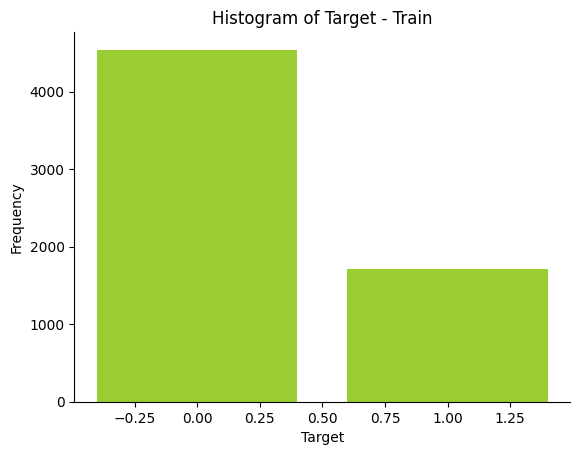

In [10]:
plt.bar(train_host['unlisted'].value_counts().index,train_host['unlisted'].value_counts().values, color = "yellowgreen")
plt.grid(False)
plt.title('Histogram of Target - Train')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [11]:
train_host.isna().sum()

index          0
description    0
host_about     0
unlisted       0
dtype: int64

In [12]:
train_reviews.isna().sum()

index       0
comments    2
dtype: int64

In [13]:
train_host['word_count_description']  = train_host['description'].apply(lambda x: len(str(x).split(" ")))
train_host['word_count_host_about']  = train_host['host_about'].apply(lambda x: len(str(x).split(" ")))
train_host.head()

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

   word_count_description  word_count_host_about  
0                     127                      4  
1                      23                     24  
2                     170                     45  
3                      47                     31  
4                     101                     37

In [14]:
train_reviews['word_count_comments']  = train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
train_reviews.head()

index                                           comments  \
0      1  this is a very cozy and comfortable house to s...   
1      1                                          good<br/>   
2      1  My first hostel experience, and all I have to ...   
3      1  Das Hostel war neu und deshalb funktionierte a...   
4      1  It was fine for a dorm, but I think for the pe...   

   word_count_comments  
0                   28  
1                    1  
2                  261  
3                   81  
4                   27

In [15]:
train_host[['word_count_description', 'word_count_host_about']].describe()

word_count_description  word_count_host_about
count             6248.000000            6248.000000
mean               132.860755              73.653009
std                 48.084904              79.660191
min                  3.000000               1.000000
25%                 99.000000              26.000000
50%                157.000000              55.000000
75%                167.000000             101.000000
max                210.000000            1387.000000

In [16]:
train_reviews[['word_count_comments']].describe()

word_count_comments
count        361281.000000
mean             47.973107
std              46.788908
min               1.000000
25%              18.000000
50%              36.000000
75%              63.000000
max            1019.000000

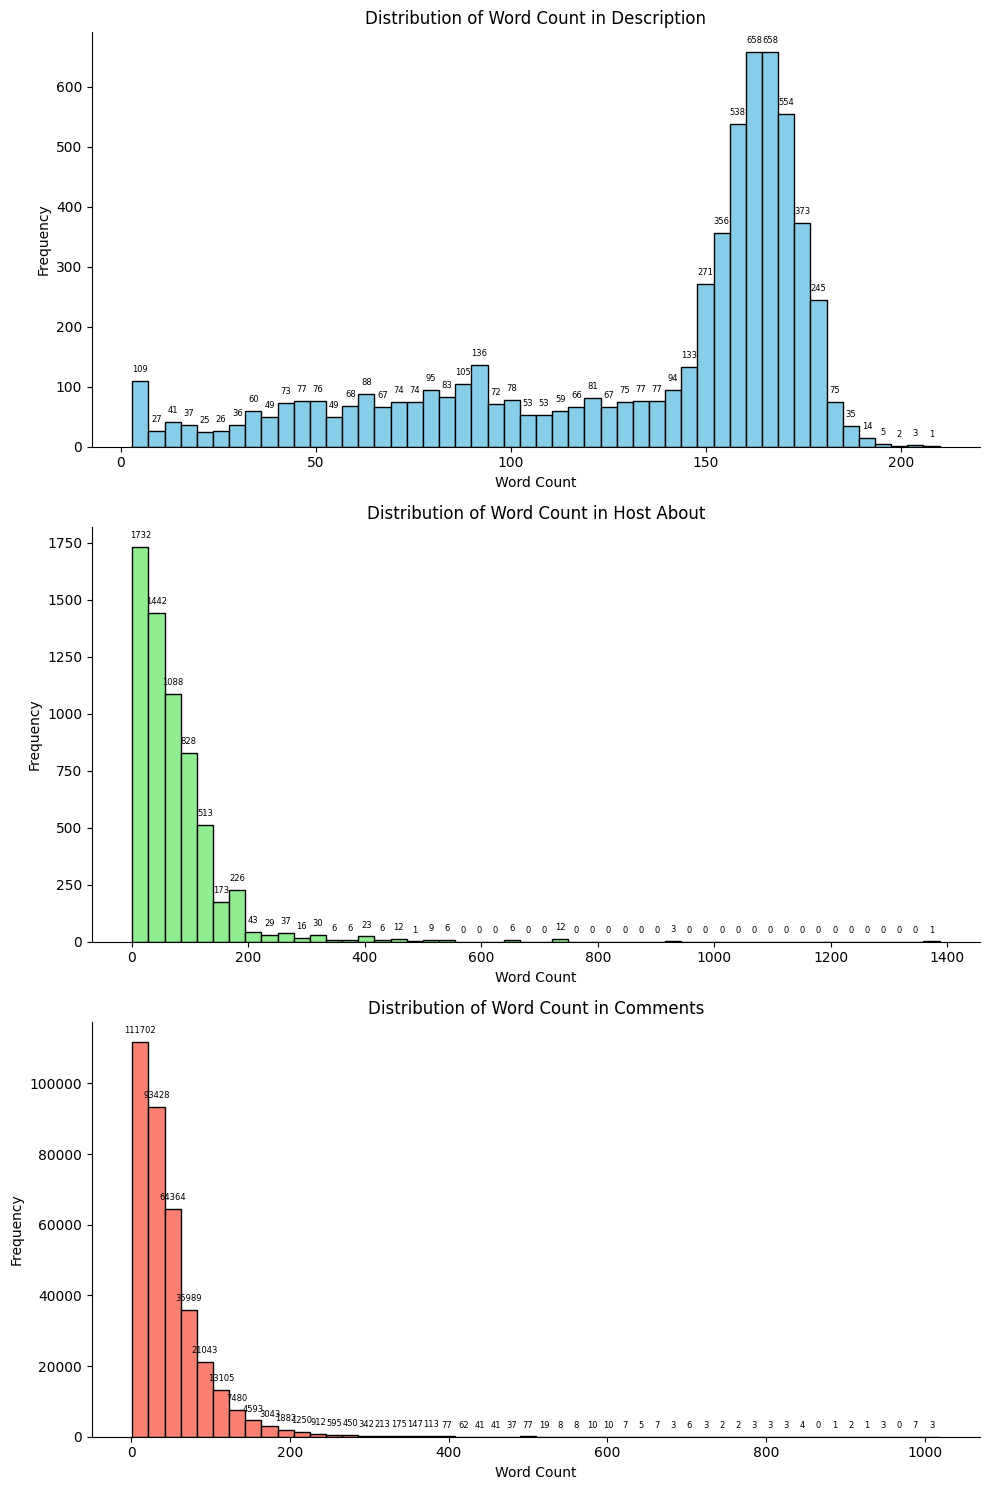

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

counts_desc, bins_desc, _ = axs[0].hist(train_host['word_count_description'], bins=50, color='skyblue', edgecolor='black')
axs[0].grid(False)
axs[0].set_title('Distribution of Word Count in Description')
axs[0].set_xlabel('Word Count')
axs[0].set_ylabel('Frequency')

counts_about, bins_about, _ = axs[1].hist(train_host['word_count_host_about'], bins=50, color='lightgreen', edgecolor='black')
axs[1].grid(False)
axs[1].set_title('Distribution of Word Count in Host About')
axs[1].set_xlabel('Word Count')
axs[1].set_ylabel('Frequency')

counts_comments, bins_comments, _ = axs[2].hist(train_reviews['word_count_comments'], bins=50, color='salmon', edgecolor='black')
axs[2].grid(False)
axs[2].set_title('Distribution of Word Count in Comments')
axs[2].set_xlabel('Word Count')
axs[2].set_ylabel('Frequency')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add annotations to the top of each bar
for ax, counts, bins in zip(axs, [counts_desc, counts_about, counts_comments], [bins_desc, bins_about, bins_comments]):
    for count, bin_edge in zip(counts, bins):
        ax.annotate(str(int(count)), xy=(bin_edge + (bins[1] - bins[0]) / 2, count),
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize = 6)

plt.tight_layout()
plt.show()


In [18]:
all_words_comments = ' '.join(train_reviews['comments'].dropna()).split()
freq_comments = pd.Series(all_words_comments).value_counts()
freq_comments.sort_values(ascending=False)[0:10]

and     553157
the     515963
a       398631
to      328675
is      258191
in      249469
was     239807
of      174087
very    156654
The     143987
Name: count, dtype: int64

In [19]:
all_words_description= ' '.join(train_host['description'].dropna()).split()
freq_description= pd.Series(all_words_description).value_counts()
freq_description.sort_values(ascending=False)[0:10]

the      31323
and      27698
a        25540
/><br    17380
to       15328
of       15122
in       13866
with     13649
is       12083
de        6918
Name: count, dtype: int64

In [20]:
all_words_host_about= ' '.join(train_host['host_about'].dropna()).split()
freq_host_about= pd.Series(all_words_host_about).value_counts()
freq_host_about.sort_values(ascending=False)[0:10]

and    16358
to     13291
the    10797
a      10535
in      9860
of      6524
I       6419
you     6248
de      4325
We      4206
Name: count, dtype: int64

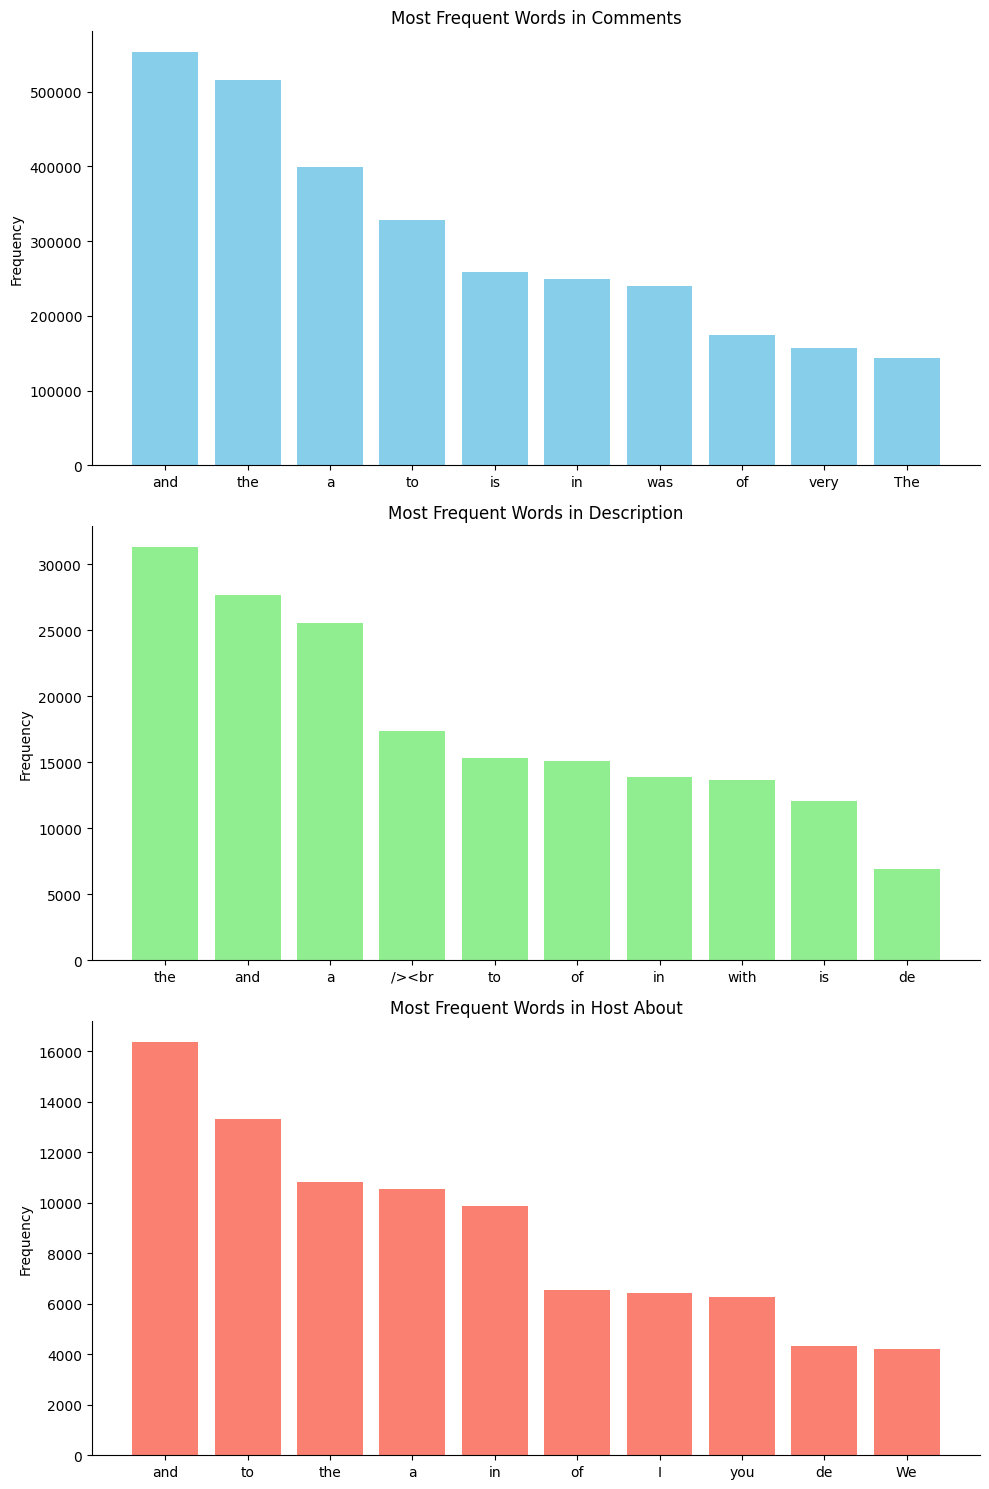

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

x_labels = freq_comments.index[:10]
values = freq_comments[:10]
axs[0].bar(x_labels, values, color='skyblue')
axs[0].set_xticks(x_labels)
axs[0].set_ylabel('Frequency')
axs[0].set_title('Most Frequent Words in Comments')
axs[0].grid(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


x_labels = freq_description.index[:10]
values = freq_description[:10]
axs[1].bar(x_labels, values, color='lightgreen')
axs[1].set_xticks(x_labels)
axs[1].set_ylabel('Frequency')
axs[1].set_title('Most Frequent Words in Description')
axs[1].grid(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)


x_labels = freq_host_about.index[:10]
values = freq_host_about[:10]
axs[2].bar(x_labels, values, color='salmon')
axs[2].set_xticks(x_labels)
axs[2].set_ylabel('Frequency')
axs[2].set_title('Most Frequent Words in Host About')
axs[2].grid(False)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

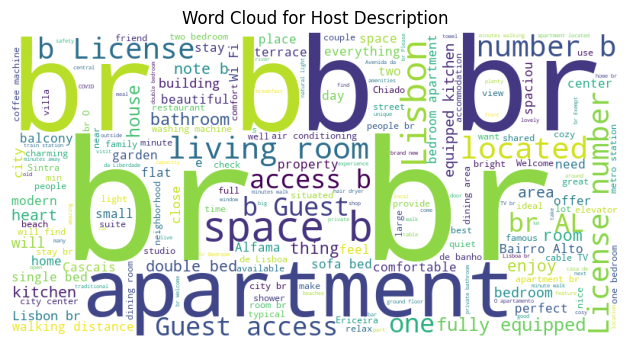

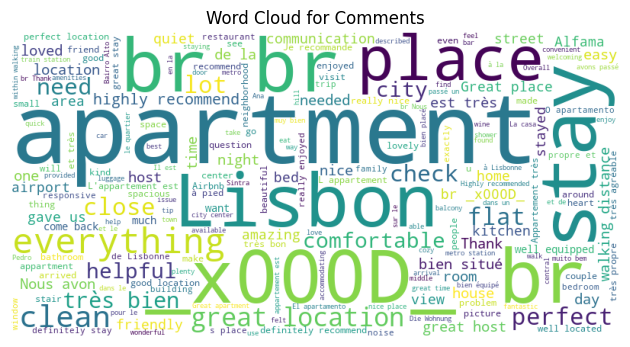

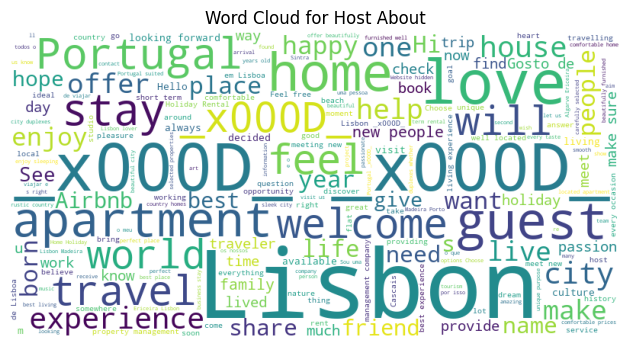

In [22]:
wordcloud_host = WordCloud(width=800, height=400, background_color="white").generate(' '.join(train_host['description']))
plt.imshow(wordcloud_host)
plt.title('Word Cloud for Host Description')
plt.axis("off")
plt.tight_layout()
plt.show()

wordcloud_reviews = WordCloud(width=800, height=400, background_color="white").generate(' '.join(train_reviews['comments'].astype(str)))
plt.imshow(wordcloud_reviews)
plt.title('Word Cloud for Comments')
plt.axis("off")
plt.tight_layout()
plt.show()

wordcloud_about = WordCloud(width=800, height=400, background_color="white").generate(' '.join(train_host['host_about']))
plt.imshow(wordcloud_about)
plt.title('Word Cloud for Host About')
plt.axis("off")
plt.tight_layout()
plt.show()


In [25]:
# Concatenate all text columns into a single Series
text_series = pd.concat([train_host['description'], train_host['host_about'], train_reviews['comments']], ignore_index=True)

# function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'  # Handling cases where language detection fails

detected_languages = text_series.apply(detect_language)

language_counts = detected_languages.value_counts()

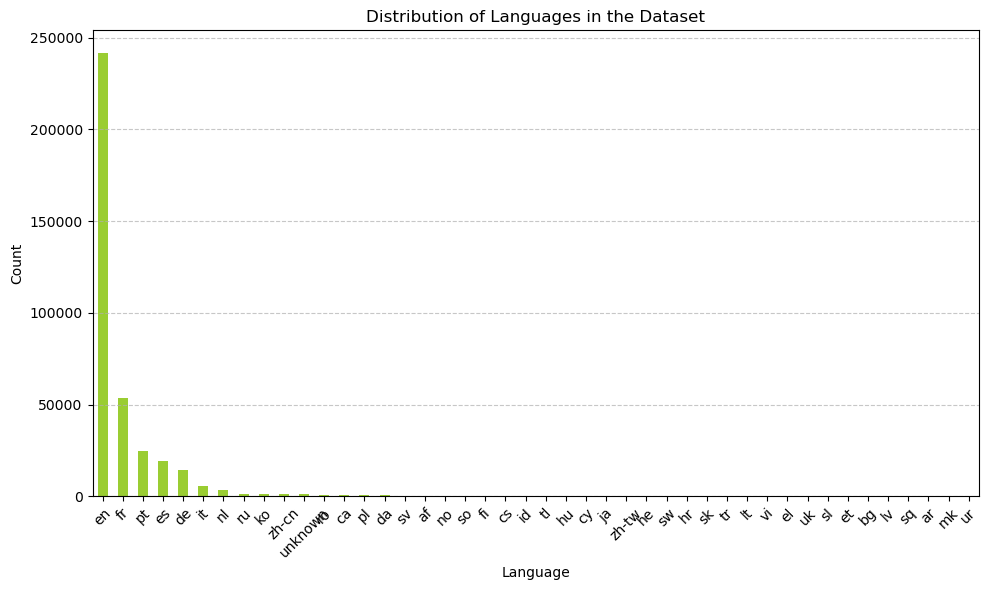

In [ ]:
# Plot the distribution of languages
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', color='yellowgreen')
plt.title('Distribution of Languages in the Dataset')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Translation

In [23]:
train_reviews_2 = train_reviews[int(len(train_reviews['comments'])/2):]

In [24]:
def translate(text):
    try:
        # Check if the text is empty or contains only special characters
        if (not text) or pd.isna(text) or text.strip() == '' or not any(char.isalnum() for char in text):
            return text
        else:
            try:
                language = detect(text)
            except LangDetectException as e:
                print(f"Language Detection Error for text '{text}': {e}")
                language = 'unknown'

            if language != 'en' and language != 'unknown':
                if language == 'zh-cn':
                    try:
                        translation = GoogleTranslator(source='zh-CN', target='en').translate(text)
                        return translation
                    except AttributeError as e:
                        print(f"Translation Error '{text}': {e}")
                        return text
                    except Exception as e:
                        print(f"Unexpected Error '{text}': {e}")
                        return text
                elif language == 'zh-tw':
                    try:
                        translation = GoogleTranslator(source='zh-TW', target='en').translate(text)
                        return translation
                    except AttributeError as e:
                        print(f"Translation Error '{text}': {e}")
                        return text
                    except Exception as e:
                        print(f"Unexpected Error '{text}': {e}")
                        return text
                else:
                    try:
                        translation = GoogleTranslator(source=language, target='en').translate(text)
                        return translation
                    except AttributeError as e:
                        print(f"Translation Error '{text}': {e}")
                        return text
                    except Exception as e:
                        print(f"Unexpected Error '{text}': {e}")
                        return text
            else:
                return text
    except Exception as e:
        print(f"Unexpected Error for text '{text}': {e}")
        return text


# Open the output CSV file in write mode
with open('translated_reviews_2.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Initialize the writer object
    writer = csv.writer(csvfile)
    # Write the header row (if your CSV has headers)
    writer.writerow(train_reviews_2.columns)

    # Iterate over each row in the dataset
    for index, row in tqdm(train_reviews_2.iterrows(), total=train_reviews_2.shape[0]):
        # Translate the comment
        row['comments'] = translate(row['comments'])
        # Write the entire row to the CSV file
        writer.writerow(row)

  2%|▏         | 3191/180641 [26:39<17:17:43,  2.85it/s] 

Language Detection Error for text '5*': No features in text.


  5%|▍         | 8398/180641 [59:42<32:04:42,  1.49it/s] 

Unexpected Error 'מקום נקי וברמה גבוהה. מיקום מעולה. מארח אדיב ונעים': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 

  5%|▍         | 8720/180641 [1:01:01<35:11:15,  1.36it/s]

Unexpected Error 'דירה נחמדה באזור השקט של באריו אלטו <br/>דקה מהתצפית ומיקום מצוין .<br/>אנחנו נהננו .<br/>בקיץ אולי יכול להיות בעייתי כי הדירה רק עם חזית אחת לרחוב . והחדר שינה ללא חלון .<br/>אנחנו היינו באפריל והיה סבבה .<br/>אנשים נחמדים מאוד ושמחים לעזור תמיד': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'gal

  7%|▋         | 12414/180641 [1:20:48<13:19:06,  3.51it/s]

Language Detection Error for text '5*!': No features in text.


  7%|▋         | 13336/180641 [1:23:53<14:26:18,  3.22it/s]

Unexpected Error 'הדירה הייתה יותר קטנה ממה שנראה בתמונות, וכדי להגיע אליה צריך לעלות במדרגות צרות ותלולות. המרפסת הייתה תוספת משמעותית, והיה כיף ונעים לשבת בה בבוקר ובערב. ההיענות של המארח בוואטסאפ הייתה מהירה והוא ניסה לעזור לנו בכל מה שהיינו צריכים.<br/>בסה"כ מאוד נהנינו מהשהות שלנו בעיר': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 

  8%|▊         | 13985/180641 [1:29:03<4:07:37, 11.22it/s]  

Unexpected Error 'מלון מצויין צמוד לכיכר רוסו. רכבת תחתית מעולה ואוטובוסים לכל מקום בקרבת מקום. מרחק הליכה ממרכז העיניינים. הדירה מאובזרת בכל מה שדירה צריכה למגורים. מעלית, מזגן ונוחות. מתאימה מאוד למשפחות. התקשורת עם אנה היתה מצויינת ואפילו ניסתה לעזור לנו להשאיר את המזוודות שלנו קצת מעבר לצ׳ק אווט כי הטיסה שלנו בחזור היתה בלילה. בסוף השארנו את המזוודות במלון מול הדירה בשם my story hotel במחיר של יורו למזוודה. הזמנו גם מונית לשדה התעופה דרך פקידת המלון.  יש מסעדת סושי טובה מול הדירה. ועוד המון מסעדות באיזור. ממליצה בחום.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 

  8%|▊         | 14361/180641 [1:31:28<23:49:28,  1.94it/s]

Unexpected Error 'מיקום מעולה בלב העיר, מסעדות, בתי קפה וחנויות  במרחק הליכה. שירות ויחס מצוין': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw'

  8%|▊         | 14961/180641 [1:33:51<18:05:23,  2.54it/s]

Language Detection Error for text '5*': No features in text.


  8%|▊         | 15353/180641 [1:35:29<9:16:30,  4.95it/s] 

Unexpected Error 'הדירה מקסימה וממוקמת באזור מרכזי ומאד נח.<br/>האירוח היה נעים מאד ובעל הדירה היה גמיש ונענה בחיוב לכל בקשותינו.<br/>ממליצה בחום.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'h

 11%|█         | 20105/180641 [2:04:31<23:36:56,  1.89it/s] 

Unexpected Error 'סינטרה מדהימה. קר מאוד גם באוגוסט!': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungaria

 12%|█▏        | 20882/180641 [2:09:02<25:57:56,  1.71it/s]

Unexpected Error 'В Лиссабоне мы (нас было 4ро) мы провели бОльшую часть отпуска и соответственно прожили тут 7 дней. Впечатлений масса) Начну по порядку... Квартира находится в историческом центре Лиссабона, что означает узкие улочки, отсутствие парковок, а те что есть либо платные, либо только для жителей имеющих спец разрешение, но стоит отметить, что улица на которой находится квартира имеет бесплатную парковку (ну имеет парковку, это громко сказано. Представьте себе улочку длинной примерно метров 200 под уклон (не зря Лиссабон называют город на 7 холмах) шириной ровно в одну машину (не как в России на полторы машины полоса, а ровно на ширину машины). По бокам невысокий бордюр и по идее пешеходная тропинка шириной примерно сантиметров 70-80. Теперь вы представляете общую ширину дороги. Так вот на одной стороне вдоль всей дороги стоят машины припаркованные, одним колесом заехав на бордюр и прижавшись к дому (люди выходя из дома, можно сказать упираются в твою машину, благо выход из 

 14%|█▍        | 25653/180641 [2:41:23<464:59:07, 10.80s/it]

Unexpected Error 'Local agradável, próximo Mercado, restaurantes, farmácia, área de turismo, e co. fácil deslocamento, co. acesso transporte coletivo.': ('Connection aborted.', ConnectionResetError(10054, 'Uma ligação existente foi forçada a fechar pelo anfitrião remoto', None, 10054, None))


 15%|█▍        | 26298/180641 [4:44:04<83433:23:52, 1946.06s/it]

Unexpected Error 'Ce fut un réel plaisir de séjourner dans cet appartement. Celui-ci est spacieux, propre et bien équipé. Il se situe dans un charmant quartier et  à 5 minutes d’une station de métro ( très pratique pour se déplacer). Nous n’hésiterons pas à réitérer l’expérience lors d’un prochain séjour à Lisbonne.': ('Connection aborted.', ConnectionResetError(10054, 'Uma ligação existente foi forçada a fechar pelo anfitrião remoto', None, 10054, None))


 15%|█▍        | 26897/180641 [4:49:27<12:51:54,  3.32it/s]     

Language Detection Error for text '10/10!': No features in text.


 16%|█▋        | 29695/180641 [5:22:15<57:31:15,  1.37s/it] 

Unexpected Error 'דירה מצויינת': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu', 'icelandic':

 16%|█▋        | 29713/180641 [5:22:34<60:32:46,  1.44s/it]

Unexpected Error 'Leider kann ich diese Unterkunft nicht empfehlen.<br/>Allerdings kann ich jetzt bereits sagen, wie der Gastgeber darauf reagieren wird, da bereits über sehr freundliche und bemühte Mitarbeiter des Support-Services von airbnb versucht wurde mit dem Gastgeber zu vermitteln und eine Rückerstattung zu veranlassen.<br/>Dies wurde seitens des Vermieters abgelehnt.<br/>Man muss sich nur kurz die Mühe machen seine Bewertungen zu lesen, welche offensichtlich nicht dem entsprechen was er gerne hören möchte. <br/>Solange jemand nur positives schreibt, bleibt er höflich, kaum äußert jemand Kritik, liegt es laut ihm immer nur daran, das die zahlenden Gäste an allem Schuld sind und aus seiner Sicht mit nichts zufrieden sind.<br/>Wir kamen wie geplant an, warteten vor der Unterkunft und wurden dann von einem Herrn in unsere gebuchte Unterkunft gebracht. Der Gastgeber war aufgrund einer privaten Sache zu diesem Zeitpunkt nicht vor Ort, schrieb uns das es ihm leid täte und er später v

 17%|█▋        | 31007/180641 [5:39:53<57:58:36,  1.39s/it] 

Language Detection Error for text '5✨': No features in text.


 17%|█▋        | 31215/180641 [5:43:12<19:20:16,  2.15it/s]

Language Detection Error for text '9': No features in text.


 18%|█▊        | 32075/180641 [5:53:47<10:07:19,  4.08it/s] 

Unexpected Error 'דירה נחמדה ונעימה': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu', 'icelan

 18%|█▊        | 32261/180641 [5:56:06<41:44:09,  1.01s/it] 

Unexpected Error 'המיקום טוב, נמצא ליד סופר שבו ניתן לערוך קניות .<br/>הדירה משופצת ויפה כוללת חדר שינה,סלון קטן שכולל בתוכו מטבחון. וחדרון של מקלחת .ושרותים.<br/>הדירה מאובזרת למעט כמה פרטים קטנים .<br/>היינו מרוצים והיינו בהחלט חוזרים לשם.<br/>המחיר קצת יקר לעומת הסביבה.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': '

 19%|█▉        | 34777/180641 [6:30:20<4:27:38,  9.08it/s]  

Unexpected Error 'המיקום מדהיים! בעיר העתיקה, צמוד לטירה היסטורית יפייפיה, יש בית קפה מקסים מתחת לדירה, הדירה הייתה אפילו יותר יפה מבתמונות, פטריסיה הייתה מאוד חמודה והשאירה לנו הפתעות קטנות בדירה, הדירה נקיה ויש בה ריח מדהים בכל אזור, כולל המצעים, גם בבניין היה כל הזמן ריח טוב. אנחנו הגענו ביולי ויש מזגן בדירה שממש היה הכרחי. למי שמטייל לראשונה בפורטוגל אנחנו ממליצים ממש, השכונה שקטה והיא במרחק הליכה לכל אזורי הבילוי והקניות. ללא ספק זוהי מציאה! ממליצים ממש בחום!!❤️': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'c

 21%|██        | 37068/180641 [7:34:34<6298:48:49, 157.94s/it]

Unexpected Error 'Ubicación perfecta y comunicación genial en cualquier momento , con un detalle que nos vino súper bien de guardarnos las maletas por la mañana el día que nos fuimos. Gracias': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Ubicaci%C3%B3n+perfecta+y+comunicaci%C3%B3n+genial+en+cualquier+momento+%2C+con+un+detalle+que+nos+vino+s%C3%BAper+bien+de+guardarnos+las+maletas+por+la+ma%C3%B1ana+el+d%C3%ADa+que+nos+fuimos.+Gracias (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85F1B290>: Failed to resolve 'translate.google.com' ([Errno 11004] getaddrinfo failed)"))
Unexpected Error 'Ubicación y servicios perfectos!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Ubicaci%C3%B3n+y+servicios+perfectos%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B8C6C0140>: Failed to resolve '

 22%|██▏       | 39133/180641 [8:00:33<36:43:45,  1.07it/s]   

Language Detection Error for text '5*': No features in text.


 23%|██▎       | 42346/180641 [8:40:36<18:00:18,  2.13it/s] 

Unexpected Error 'דירה מצויינת ומארח מצוין': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu', 

 24%|██▍       | 43516/180641 [14:21:41<46108:19:05, 1210.50s/it] 

Unexpected Error 'Anfitrião muito simpático e prestável! Casa cinco estrelas com uma decoração minimalista e de muito bom gosto. Muito bem localizada, com todas as comodidades! Nada a apontar, recomendo!': Response ended prematurely
Unexpected Error 'great experience.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=ro&q=great+experience. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B64C560>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Carlos foi um fantastico anfitriao! A casa era grande e estava impecavel!<br/>Recomendo a todos que queiram ter um fim de semana de sossego em Sintra ou até mesmo se quiserem visitar Lisboa!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Carlos+foi+um+fantastico+anfitriao%21+A+casa+era+grande+e+estava+impecavel%21%3Cbr%2F%3ERecomendo+a+todos+

 24%|██▍       | 43547/180641 [14:21:42<6691:53:17, 175.72s/it]  

Unexpected Error 'Hola, la casa es muy cómoda, esta en una zona buena para visitar lisboa. La recomiendo.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Hola%2C+la+casa+es+muy+c%C3%B3moda%2C+esta+en+una+zona+buena+para+visitar+lisboa.+La+recomiendo. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B612840>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Duplex bien situé, desservi par le tramway 28 qui permet de sillonner dans Lisbonne . Duplex confortable avec toutes les commoditees . ': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Duplex+bien+situ%C3%A9%2C+desservi+par+le+tramway+28+qui+permet+de+sillonner+dans+Lisbonne+.+Duplex+confortable+avec+toutes+les+commoditees+. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA1CAD0>: Fail

 24%|██▍       | 43555/180641 [14:21:42<4696:06:40, 123.32s/it]

Unexpected Error 'Séjour parfait situation géographique permettant de faire une bonne partie de lisbonne à pied.Accueil chaleureux. A conseiller': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=S%C3%A9jour+parfait+situation+g%C3%A9ographique+permettant+de+faire+une+bonne+partie+de+lisbonne+%C3%A0+pied.Accueil+chaleureux.+A+conseiller (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA1FB90>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Nous avons séjourné chez Philippe pendant les fêtes de la Saint Antoine sans le savoir, c’était très festif ! Un bel appartement bien situe dans le quartier de Graça, les transports et les commerces sont à 2 pas, le Château St Georges et les 2 plus belles vues de la ville sont tous proches. ': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Nous

 24%|██▍       | 43571/180641 [14:21:42<2308:10:05, 60.62s/it] 

Unexpected Error 'Très bel appartement bien décoré et très bien équipé. ( un peu de bruit la nuit) dans un quartier très sympa, tram 28 à côté avec pleins de petits commerces, restos et proche du centre. Accueil chaleureux': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+bel+appartement+bien+d%C3%A9cor%C3%A9+et+tr%C3%A8s+bien+%C3%A9quip%C3%A9.+%28+un+peu+de+bruit+la+nuit%29+dans+un+quartier+tr%C3%A8s+sympa%2C+tram+28+%C3%A0+c%C3%B4t%C3%A9+avec+pleins+de+petits+commerces%2C+restos+et+proche+du+centre.+Accueil+chaleureux (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B7C6480>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Nous avons passé un EXCELLENT séjour ! L'appartement confortable et chalereux est idéalement placé dans le sympathique quartier de Graça, dans une rue calme, tout près de super restos bon marchés !  Allez y l

 24%|██▍       | 43578/180641 [14:21:42<1680:05:38, 44.13s/it]

Unexpected Error 'Beau logement, bien équipé, ambiance conviviale, très jolie terrasse meublée, secteur tranquille, emplacement parfait, près de commerces sympathiques. Idéal pour une famille de 4.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Beau+logement%2C+bien+%C3%A9quip%C3%A9%2C+ambiance+conviviale%2C+tr%C3%A8s+jolie+terrasse+meubl%C3%A9e%2C+secteur+tranquille%2C+emplacement+parfait%2C+pr%C3%A8s+de+commerces+sympathiques.+Id%C3%A9al+pour+une+famille+de+4. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85854FB0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Super séjour, super accueil, appartement magnifique... rien à critiquer!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Super+s%C3%A9jour%2C+super+accueil%2C+appartement+magnifique...+rien+%C3%A0+critiquer%21 (C

 24%|██▍       | 43591/180641 [14:21:43<901:19:49, 23.68s/it] 

Unexpected Error 'L'appartement est très bien équipé, a une petite cour agréable et est situé dans un quartier idéal pour découvrir Lisbonne, faire quelques courses et prendre son petit-déjeuner. Il y a plein de restaurants et on est à côté du tram 28. Nous recommandons cet appartement dans le quartier de Graça.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=L%27appartement+est+tr%C3%A8s+bien+%C3%A9quip%C3%A9%2C+a+une+petite+cour+agr%C3%A9able+et+est+situ%C3%A9+dans+un+quartier+id%C3%A9al+pour+d%C3%A9couvrir+Lisbonne%2C+faire+quelques+courses+et+prendre+son+petit-d%C3%A9jeuner.+Il+y+a+plein+de+restaurants+et+on+est+%C3%A0+c%C3%B4t%C3%A9+du+tram+28.+Nous+recommandons+cet+appartement+dans+le+quartier+de+Gra%C3%A7a. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B81140770>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Nice apartment!': 

 24%|██▍       | 43608/180641 [14:21:43<407:03:28, 10.69s/it]

Unexpected Error 'Wir haben eine angenehme Woche in Lissabon verbracht. Die Unterkunft ist für die Erkundung der Stadt äußerst gut gelegen. Die Wohnung hat alles was es benötigt um eine gut Zeit zu haben.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Wir+haben+eine+angenehme+Woche+in+Lissabon+verbracht.+Die+Unterkunft+ist+f%C3%BCr+die+Erkundung+der+Stadt+%C3%A4u%C3%9Ferst+gut+gelegen.+Die+Wohnung+hat+alles+was+es+ben%C3%B6tigt+um+eine+gut+Zeit+zu+haben. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B64FE90>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Appartement super cosy, à deux pas du célèbre tram 28, tout en étant super calme. Terrasse agréable en RDC sans vis à vis, un grand atout de plus pour profiter du beau temps. Accueil au top avec tous les conseils pour être comme un poisson dans l'eau dès son arrivée à Lisbonne. En 

 24%|██▍       | 43629/180641 [14:21:43<165:25:33,  4.35s/it]

Unexpected Error 'vraiment agréable proche du Tram 28E  resto autour sympas, facilité pour prendre prendre ticket bus/tram sur la place de Graça et proche d' Alfama. appartement très agréable avec sa terrasse et clim également.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=vraiment+agr%C3%A9able+proche+du+Tram+28E++resto+autour+sympas%2C+facilit%C3%A9+pour+prendre+prendre+ticket+bus%2Ftram+sur+la+place+de+Gra%C3%A7a+et+proche+d%27+Alfama.+appartement+tr%C3%A8s+agr%C3%A9able+avec+sa+terrasse+et+clim+%C3%A9galement. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B64F9E0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Très bon logement, super emplacement !': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+bon+logement%2C+super+emplacement+%21 (Caused by NameResoluti

 24%|██▍       | 43647/180641 [14:21:43<82:22:23,  2.16s/it] 

Unexpected Error 'ha sido todo genial.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=ha+sido+todo+genial. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA5C4A0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Merci Philipe et merci Ana Luisa pour nous avoir accueilli dans l'appartement et nous avoir expliqué toutes les choses à savoir.<br/>Notre séjour a été très agréable, dans un quartier superbe, proche d'un arrêt de la  ligne de tramway 28. Nous en avons abusé le plus possible pour nous faufiler dans la ville, monter et descendre les "traversa", au plus proche des monuments et des différents quartiers, en léchant les vitrines des petits magasins et des restaurants qui nous tenaient tous les cinq en haleine.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Merci+Philipe

 24%|██▍       | 43670/180641 [14:21:44<36:18:13,  1.05it/s]

Unexpected Error 'Otima localização, muito bem decorado e bastante acolhedor<br/>Um pouco mais de brio na limpeza e setia excecional': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Otima+localiza%C3%A7%C3%A3o%2C+muito+bem+decorado+e+bastante+acolhedor%3Cbr%2F%3EUm+pouco+mais+de+brio+na+limpeza+e+setia+excecional (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA02900>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Bon emplacement et qualité du logement': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Bon+emplacement+et+qualit%C3%A9+du+logement (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA026F0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Fotos reais, apartamento muito bem cons

 24%|██▍       | 43680/180641 [14:21:44<25:42:29,  1.48it/s]

Unexpected Error 'Central apartment': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=ca&q=Central+apartment (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B813F0860>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Logement idéalement placé': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Logement+id%C3%A9alement+plac%C3%A9 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B813F11F0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Net appartement op een zeer goede locatie. Het balkon is precies goed om met 2 stoeltjes op te zitten.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=nl&q=Net+appartement+op+een+zeer+goede+locatie.+Het+balkon+is+pr

 24%|██▍       | 43714/180641 [14:21:44<8:03:49,  4.72it/s] 

Unexpected Error 'Zeer gezellig appartementje in het centrum van Lissabon. De communicatie verliep zeer vlot, de eigenaars waren zeer beschikbaar en vriendelijk, klaar om je te helpen. Het appartement is zeer goed voorzien, leuk ingericht en proper onderhouden! Wij hebben er een fantastisch verblijf gehad en raden het zeker aan! ': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=nl&q=Zeer+gezellig+appartementje+in+het+centrum+van+Lissabon.+De+communicatie+verliep+zeer+vlot%2C+de+eigenaars+waren+zeer+beschikbaar+en+vriendelijk%2C+klaar+om+je+te+helpen.+Het+appartement+is+zeer+goed+voorzien%2C+leuk+ingericht+en+proper+onderhouden%21+Wij+hebben+er+een+fantastisch+verblijf+gehad+en+raden+het+zeker+aan%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85CCF3B0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Das Appartement hat den Bildern absolut

 24%|██▍       | 43725/180641 [14:21:44<5:49:44,  6.52it/s]

Unexpected Error 'L appartement est très bien équipé et d une propreté assez remarquable. La chambre est un peu en retrait de la rue ce qui est un plus. Charmant accueil de Cristina. ': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=L+appartement+est+tr%C3%A8s+bien+%C3%A9quip%C3%A9+et+d+une+propret%C3%A9+assez+remarquable.+La+chambre+est+un+peu+en+retrait+de+la+rue+ce+qui+est+un+plus.+Charmant+accueil+de+Cristina. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85D2D640>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'L'appartement est très bien situé, dans une petite rue à 300m d'une station de métro et à quelques minutes à pied du centre ville. Nous n'avons presque pas utilisé les transports en commun. Alexandra a été très réactive aux messages et a répondu avec efficacité à mes questions. Nous avons été bien accueillis par Cristina. L

 24%|██▍       | 43751/180641 [14:21:44<2:46:23, 13.71it/s]

Unexpected Error 'Die Wohnung war super sauber, hatte alles was man braucht und man könnte Lissabon ideal zu Fuß erkunden ansonsten ist die Metro auch nur 5 min entfernt.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Die+Wohnung+war+super+sauber%2C+hatte+alles+was+man+braucht+und+man+k%C3%B6nnte+Lissabon+ideal+zu+Fu%C3%9F+erkunden+ansonsten+ist+die+Metro+auch+nur+5+min+entfernt. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA1DC40>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Très bel appartement très bien situé, Joanna est très accueillante! Idéal pour un couple': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+bel+appartement+tr%C3%A8s+bien+situ%C3%A9%2C+Joanna+est+tr%C3%A8s+accueillante%21+Id%C3%A9al+pour+un+couple (Caused by NameResolutionError("<urllib3.

 24%|██▍       | 43775/180641 [14:21:45<1:33:10, 24.48it/s]

Unexpected Error 'Très beau petit studio, pas loin du métro et de petits commerces. Seul bémol est le bruit environnant, qui s’entend très bien. On peut joindre quelqu’un en cas de problème. Tout c’est bien passé.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+beau+petit+studio%2C+pas+loin+du+m%C3%A9tro+et+de+petits+commerces.+Seul+b%C3%A9mol+est+le+bruit+environnant%2C+qui+s%E2%80%99entend+tr%C3%A8s+bien.+On+peut+joindre+quelqu%E2%80%99un+en+cas+de+probl%C3%A8me.+Tout+c%E2%80%99est+bien+pass%C3%A9. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B81434CE0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Very nice !': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=cs&q=Very+nice+%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7C

 24%|██▍       | 43787/180641 [14:21:45<1:15:49, 30.08it/s]

Unexpected Error 'Excellent séjour passé chez João and Leonor qui ont été très arrangeantes concernant le check in. Appartement joliement décoré et bien équipé dans le coeur de Lisbonne. Je recommande.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Excellent+s%C3%A9jour+pass%C3%A9+chez+Jo%C3%A3o+and+Leonor+qui+ont+%C3%A9t%C3%A9+tr%C3%A8s+arrangeantes+concernant+le+check+in.+Appartement+joliement+d%C3%A9cor%C3%A9+et+bien+%C3%A9quip%C3%A9+dans+le+coeur+de+Lisbonne.+Je+recommande. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B810BE090>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Un quartier authentique et vivant': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Un+quartier+authentique+et+vivant (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x

 24%|██▍       | 43806/180641 [14:21:45<59:51, 38.10it/s]  

Unexpected Error 'Rien à redire très correct.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Rien+%C3%A0+redire+tr%C3%A8s+correct. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B8C6C1220>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'El apartamento es tal y como se ve en las fotos. Pequeñito pero tiene todo lo necesario para una estancia corta. Me sorprendió para mal el hecho de que no tuviera armario ni algún tipo de barra para colgar la ropa, únicamente un pequeño mueble para guardar ropa doblada y un gancho detrás de la puerta de la habitación. Cabe destacar, también, que las paredes son, en su mayoría, de pladur, y que el apartamento está en un primero pero más que un primero es un entreplantas, lo que provoca que se oiga absolutamente todo: los vecinos, las escaleras, voces,... como si no hubiera paredes. Igualmente, esto no ha

 24%|██▍       | 43825/180641 [14:21:45<44:50, 50.86it/s]

Unexpected Error 'very nice': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=cs&q=very+nice (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B810562A0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error '바퀴벌레 나옵니다.<br/>참고하시고 예약하세요.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=ko&q=%EB%B0%94%ED%80%B4%EB%B2%8C%EB%A0%88+%EB%82%98%EC%98%B5%EB%8B%88%EB%8B%A4.%3Cbr%2F%3E%EC%B0%B8%EA%B3%A0%ED%95%98%EC%8B%9C%EA%B3%A0+%EC%98%88%EC%95%BD%ED%95%98%EC%84%B8%EC%9A%94. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85855760>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Appartement bien situé au cœur du plus ancien quartier d'Alfama, proche du métro Martim Moriz. Logement bien équipé. Propriétaire arrangeant pou

 24%|██▍       | 43850/180641 [14:21:46<30:31, 74.70it/s]

Unexpected Error 'Es importante saber que el acceso es por la Puerta del hotel que hace esquina XL Rossio hotel': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Es+importante+saber+que+el+acceso+es+por+la+Puerta+del+hotel+que+hace+esquina+XL+Rossio+hotel (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA02420>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'posizione eccellente, pulizia davvero eccellente sia della camera che dei bagni. Letti comodi, ci tornero sicuramente': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=it&q=posizione+eccellente%2C+pulizia+davvero+eccellente+sia+della+camera+che+dei+bagni.+Letti+comodi%2C+ci+tornero+sicuramente (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3BBFCC20>: Failed to resolve 'translate.google.com

 24%|██▍       | 43874/180641 [14:21:46<25:05, 90.82it/s]

Unexpected Error 'Buena casa y  Buena localización. A estrenar. ': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Buena+casa+y++Buena+localizaci%C3%B3n.+A+estrenar. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA5CDA0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Wir waren zu sechst von Freitag bis Montag in Lissabon. Die Unterkunft ist wirklich sehr hübsch und vor allen Dingen sehr zentral gelegen. Einen Parkplatz haben wir an Anreisetag zum Glück gleich unmittelbar neben der Unterkunft gefunden. Ansonsten gibt es aber auch ganz in der Nähe einen Parkplatz gegen Gebühr.<br/>Beim Wäsche waschen und Benutzen des Herds ist leider immer wieder die Sicherung herausgesprungen. Wir haben dann aber während des Waschgangs nur den Strom für die Waschmaschine angelassen und so hat es dann doch noch geklappt :)': HTTPSConnectionPool(host='tr

 24%|██▍       | 43900/180641 [14:21:46<21:23, 106.50it/s]

Unexpected Error 'É um apartamento agradável, temos uma boa experiência em Lisboa:D<br/>O apartamento está na alta, ao lado daquele, pode ver a vista da cidade .': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=%C3%89+um+apartamento+agrad%C3%A1vel%2C+temos+uma+boa+experi%C3%AAncia+em+Lisboa%3AD%3Cbr%2F%3EO+apartamento+est%C3%A1+na+alta%2C+ao+lado+daquele%2C+pode+ver+a+vista+da+cidade+. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B810B2ED0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Appartement propre et très bien situé. La décoration est très sympa. Idéal pour une famille.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Appartement+propre+et+tr%C3%A8s+bien+situ%C3%A9.+La+d%C3%A9coration+est+tr%C3%A8s+sympa.+Id%C3%A9al+pour+une+famille. (Caused by NameResolutionError("<

 24%|██▍       | 43925/180641 [14:21:46<21:57, 103.77it/s]

Unexpected Error 'L’appartement est bien placée, mais n’est pas à la hauteur du prix demandé. Nous étions 8 et il n’y avait que 5 tasses à café, 5 verres à eau et 6 verres à vin. La machine à café était en panne et nous avons demandé le changement de celle-ci. Il y a un gros problème d’alimentation électrique car le four faisait déclencher le disjoncteur électrique dès que nous dépassions les 150°; difficile de faire cuire des pizzas à cette température. Si nous mettions en marche le fer à repasser et le sèche-cheveux; cela faisait aussi déclencher le disjoncteur. Il manque des équipements de base, comme louche, lèche-frites, planche à découper... etc.<br/>Deux couettes avaient des taches de sang et d’urine. <br/>Je suis très très déçu de cette location.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=L%E2%80%99appartement+est+bien+plac%C3%A9e%2C+mais+n%E2%80%99est+pas+%C3%A0+la+hauteur+du+prix+demand%C3%A9.+Nous+%C3%A9tions

 24%|██▍       | 43952/180641 [14:21:46<21:32, 105.75it/s]

Unexpected Error 'Buena relacion precio': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Buena+relacion+precio (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B7FFC50>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Nuestra experiencia no ha sido buena. <br/>La comunicación muy lenta, escribímos un mensaje para decirle que se había descolgado la mampara y no nos ha contestado ni se ha molestado en intentar solucionarlo. Por tanto solo hemos podido usar una ducha.<br/>Menaje de la cocina muy escaso, ni siquiera una ensaladera. <br/>La luz es un desastre. Imposible 2 electrodomésticos a la vez. De hecho, no hemos podido usar la lavadora porque se cortaba la luz. Hay vitriceramica pero no se puede usar por el problema de la luz, de hecho hay un camping gas para cocinar.<br/>Los desagües de lavabos y ducha van muy lentos.<br/>Zonas comunes 

 24%|██▍       | 43974/180641 [14:21:47<22:42, 100.34it/s]

Unexpected Error 'Schönes und sauberes Apartment mit super Lage direkt am Miradouro da Graca': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Sch%C3%B6nes+und+sauberes+Apartment+mit+super+Lage+direkt+am+Miradouro+da+Graca (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010BECB614F0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Ragazzo simpatico, casa molto accogliente ed elegante. La zona è davvero bella e la posizione è funzionale. Siamo stati molto bene.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=it&q=Ragazzo+simpatico%2C+casa+molto+accogliente+ed+elegante.+La+zona+%C3%A8+davvero+bella+e+la+posizione+%C3%A8+funzionale.+Siamo+stati+molto+bene. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B81056B10>: Failed to resolve 'translate.google.

 24%|██▍       | 44001/180641 [14:21:47<20:15, 112.42it/s]

Unexpected Error 'L'appartement est très bien situé, en plein cœur historique de Lisbonne. Toutes les commerces sont à deux pas de la maison, ainsi que l'arrêt de fameux tramway 28. En même temps l'appartement est très calme et spacieux, cela permet de bien se reposer après des journées remplis des visites. João est un hôte très sympathique. Je recommande vivement.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=L%27appartement+est+tr%C3%A8s+bien+situ%C3%A9%2C+en+plein+c%C5%93ur+historique+de+Lisbonne.+Toutes+les+commerces+sont+%C3%A0+deux+pas+de+la+maison%2C+ainsi+que+l%27arr%C3%AAt+de+fameux+tramway+28.+En+m%C3%AAme+temps+l%27appartement+est+tr%C3%A8s+calme+et+spacieux%2C+cela+permet+de+bien+se+reposer+apr%C3%A8s+des+journ%C3%A9es+remplis+des+visites.+Jo%C3%A3o+est+un+h%C3%B4te+tr%C3%A8s+sympathique.+Je+recommande+vivement. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3BBFDDC0>: F

 24%|██▍       | 44025/180641 [14:21:47<20:08, 113.07it/s]

Unexpected Error 'Je re commande à 100% c’était vraiment propre et bien situé': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Je+re+commande+%C3%A0+100%25+c%E2%80%99%C3%A9tait+vraiment+propre+et+bien+situ%C3%A9 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B8802A7B0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Bonne communication avec le propriétaire; le logement est très bien situé et bien équipé. Le quartier est vivant, avec des commerces nombreux et pratiques (boulangerie, cafés et restaurants, supermarché, mercerie, bazar, coiffeur, parfumerie, fleuriste). Le tram 28 et 12 desservent le quartier et un bureau de tabac pour acheter une carte de transport se situe juste à côté.<br/>Mais à pied, tous les quartiers historiques se situent à 10 minutes environ. C'est bien agréable !!': HTTPSConnectionPool(host='translate.google.com', 

 24%|██▍       | 44037/180641 [14:21:47<25:54, 87.88it/s] 

Unexpected Error 'Sehr zentral gelegen, toller Platz mit guten Restaurants um die Ecke. Alles schnell zu Fuß erreichbar.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Sehr+zentral+gelegen%2C+toller+Platz+mit+guten+Restaurants+um+die+Ecke.+Alles+schnell+zu+Fu%C3%9F+erreichbar. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B7FD400>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Joao es un buen anfitrión y la estancia fue perfecta': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Joao+es+un+buen+anfitri%C3%B3n+y+la+estancia+fue+perfecta (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3B7FDB20>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Zentrale Lage, Einkaufsmöglichkeiten im direkt

 24%|██▍       | 44064/180641 [14:21:48<21:52, 104.07it/s]

Unexpected Error 'Gostamos muito do apartamento do João. Respostas rápidas. Apartamento limpo e muito bem organizado': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Gostamos+muito+do+apartamento+do+Jo%C3%A3o.+Respostas+r%C3%A1pidas.+Apartamento+limpo+e+muito+bem+organizado (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85CCD910>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Ha estado muy chulo, muy bien cuidado y en muy buena ubicación. Nos ha atendido muy amablemente y siempre preocupándose de si nos lo estábamos pasando bien y me parece perfecto que se preocupe por cómo se lo están pasando sus huéspedes.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Ha+estado+muy+chulo%2C+muy+bien+cuidado+y+en+muy+buena+ubicaci%C3%B3n.+Nos+ha+atendido+muy+amablemente+y+siempre+preocup%

 24%|██▍       | 44089/180641 [14:21:48<20:32, 110.77it/s]

Unexpected Error 'Uma das melhores experiências em Lisboa.<br/>A casa é aconchegante, tem tudo o necessário para uma curta estadia. Vizinhança é muito boa, bons restaurantes e bares. Supermercado e padarias. Localização excelente. Fácil acesso à alfama é bairro baixo. Recomendo.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Uma+das+melhores+experi%C3%AAncias+em+Lisboa.%3Cbr%2F%3EA+casa+%C3%A9+aconchegante%2C+tem+tudo+o+necess%C3%A1rio+para+uma+curta+estadia.+Vizinhan%C3%A7a+%C3%A9+muito+boa%2C+bons+restaurantes+e+bares.+Supermercado+e+padarias.+Localiza%C3%A7%C3%A3o+excelente.+F%C3%A1cil+acesso+%C3%A0+alfama+%C3%A9+bairro+baixo.+Recomendo. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B858CA9C0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'O apartmento eh exatemente igual as fotos. Quartos grandes, camas boas super confortavel. Ba

 24%|██▍       | 44116/180641 [14:21:48<18:52, 120.54it/s]

Unexpected Error 'Superbe cottage dans les bois dans une région magnifique.<br/>L'endroit est idéalement situé entre la côte, Sintra et Cascaï.<br/>Le lieu est paisible et reposant.<br/>Diogo vous accueillera avec gentillesse et bienveillance.<br/><br/>Beautiful cottage in the woods in a beautiful area.<br/>The place is ideally located between the coast, Sintra and Cascaï.<br/>The place is peaceful and relaxing.<br/><br/>Diogo will welcome you with kindness.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Superbe+cottage+dans+les+bois+dans+une+r%C3%A9gion+magnifique.%3Cbr%2F%3EL%27endroit+est+id%C3%A9alement+situ%C3%A9+entre+la+c%C3%B4te%2C+Sintra+et+Casca%C3%AF.%3Cbr%2F%3ELe+lieu+est+paisible+et+reposant.%3Cbr%2F%3EDiogo+vous+accueillera+avec+gentillesse+et+bienveillance.%3Cbr%2F%3E%3Cbr%2F%3EBeautiful+cottage+in+the+woods+in+a+beautiful+area.%3Cbr%2F%3EThe+place+is+ideally+located+between+the+coast%2C+Sintra+and+Casca%C3%A

 24%|██▍       | 44154/180641 [14:21:48<15:26, 147.29it/s]

Unexpected Error '强烈推荐！': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=zh-CN&q=%E5%BC%BA%E7%83%88%E6%8E%A8%E8%8D%90%EF%BC%81 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B81143FB0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Gastgeber sind nett und hilfsbereit. Es ist zu empfehlen, dort Urlaub zu machen.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Gastgeber+sind+nett+und+hilfsbereit.+Es+ist+zu+empfehlen%2C+dort+Urlaub+zu+machen. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B880295E0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Спасибо за тёплый приём!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=ru&q=%D0%A1%D0%BF%D0%

 24%|██▍       | 44187/180641 [14:21:48<14:49, 153.38it/s]

Unexpected Error 'Nous avons passé un agréable séjour à Lisbonne , l'appartement est vraiment superbe .<br/>Tout est mis à disposition pour s'y sentir à l'aise , et Arturo est tout à fait disponible .<br/>': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Nous+avons+pass%C3%A9+un+agr%C3%A9able+s%C3%A9jour+%C3%A0+Lisbonne+%2C+l%27appartement+est+vraiment+superbe+.%3Cbr%2F%3ETout+est+mis+%C3%A0+disposition+pour+s%27y+sentir+%C3%A0+l%27aise+%2C+et+Arturo+est+tout+%C3%A0+fait+disponible+.%3Cbr%2F%3E (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3BBFCF20>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Logement très propre et très beau. Bien situé car proche des quartiers animés et desservi par le métro. L'accueil a été chaleureux et nous avons pu profiter du jaccuzzi à toute heure ! Merci :)': HTTPSConnectionPool(host='translate.google.com'

 24%|██▍       | 44203/180641 [14:21:49<15:59, 142.23it/s]

Unexpected Error 'Très réactif': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+r%C3%A9actif (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA34740>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'J’y ai été pour un EVJF avec 7 copines. Cet appartement a été le choix parfait. <br/>Arturo a été très disponible et réactif.<br/>Je vous le conseille !': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=J%E2%80%99y+ai+%C3%A9t%C3%A9+pour+un+EVJF+avec+7+copines.+Cet+appartement+a+%C3%A9t%C3%A9+le+choix+parfait.+%3Cbr%2F%3EArturo+a+%C3%A9t%C3%A9+tr%C3%A8s+disponible+et+r%C3%A9actif.%3Cbr%2F%3EJe+vous+le+conseille+%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA357C0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddr

 24%|██▍       | 44241/180641 [14:21:49<14:15, 159.43it/s]

Unexpected Error 'Très belle appartement à 10 min à pied du métro ( ligne rouge direct aéroport ) . Dommage que l’accès au jacuzzi ce face par l’entrée d’un autre bâtiment . Sinon rien à redire .': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+belle+appartement+%C3%A0+10+min+%C3%A0+pied+du+m%C3%A9tro+%28+ligne+rouge+direct+a%C3%A9roport+%29+.+Dommage+que+l%E2%80%99acc%C3%A8s+au+jacuzzi+ce+face+par+l%E2%80%99entr%C3%A9e+d%E2%80%99un+autre+b%C3%A2timent+.+Sinon+rien+%C3%A0+redire+. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010CC1AA7EC0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Excelente loft, internet boa, espaçoso e super bem localizado. Recomendo pra qualquer um que estiver visitando Lisboa.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Excelente+loft%2C+

 25%|██▍       | 44273/180641 [14:21:49<16:29, 137.77it/s]

Unexpected Error 'Ótimo apartamento , recomendo<br/>Bem localizado, confortável e aconchegante.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=%C3%93timo+apartamento+%2C+recomendo%3Cbr%2F%3EBem+localizado%2C+confort%C3%A1vel+e+aconchegante. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010CC1AA5550>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Arturo est très gentil. Nous ne l’avons pas rencontré mais il a toujours été très réactifs dans ses réponses et à souvent proposé de nous conseillers sur nos visite. <br/>Le loft est vraiment sympa.<br/>Je recommande!!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Arturo+est+tr%C3%A8s+gentil.+Nous+ne+l%E2%80%99avons+pas+rencontr%C3%A9+mais+il+a+toujours+%C3%A9t%C3%A9+tr%C3%A8s+r%C3%A9actifs+dans+ses+r%C3%A9ponses+et+%C3%A0+souvent+p

 25%|██▍       | 44312/180641 [14:21:49<14:13, 159.73it/s]

Unexpected Error 'Logement vraiment très sympa, assez atypique. Nous l’avons tous trouvé à notre goût et le recommandons.<br/>Arturo était réactif quand je l’ai sollicité.<br/>Nous n’avions pas d’eau dans le jacuzzi mais nous n’avions pas réservé le logement pour cela.<br/>Je recommande vraiment. L’épicerie devant l’appartement est très pratique, elle n’est pas grande mais il y a beaucoup de produits.<br/>Nous ne sommes pas directement dans le centre ville mais le quartier est vraiment agréable. Il y a un très beau centre sportif à 5min à pied (au niveau du parc) où nous avons pu tester le padel entre amis.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Logement+vraiment+tr%C3%A8s+sympa%2C+assez+atypique.+Nous+l%E2%80%99avons+tous+trouv%C3%A9+%C3%A0+notre+go%C3%BBt+et+le+recommandons.%3Cbr%2F%3EArturo+%C3%A9tait+r%C3%A9actif+quand+je+l%E2%80%99ai+sollicit%C3%A9.%3Cbr%2F%3ENous+n%E2%80%99avions+pas+d%E2%80%99eau+dans+le+jacu

 25%|██▍       | 44367/180641 [14:21:50<13:48, 164.49it/s]

Unexpected Error 'Super!! Sempre bom voltar à casa da Sofia, top ;)': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=ca&q=Super%21%21+Sempre+bom+voltar+%C3%A0+casa+da+Sofia%2C+top+%3B%29 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3BBFCA40>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Ligar amplo, bem ventilado, ensolarado, confortável e localização excelente. Recomendo!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Ligar+amplo%2C+bem+ventilado%2C+ensolarado%2C+confort%C3%A1vel+e+localiza%C3%A7%C3%A3o+excelente.+Recomendo%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B8BBE8320>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Excelente!': HTTPSConnectionPool(host='translate.google.

 25%|██▍       | 44407/180641 [14:21:50<12:37, 179.80it/s]

Unexpected Error 'Genial todo muy especial la casa llena de detalles amorosos': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Genial+todo+muy+especial+la+casa+llena+de+detalles+amorosos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85D1F4D0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Un merveilleux séjour chez Sofia, au cœur de Belem et à deux pas du Tage. L’appartement est superbe, chaleureux, on s’y sent tout de suite bien! Sofia est une vraiment une « super » hôtesse , disponible, enthousiaste et de bon conseil! Nous recommandons chaudement!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Un+merveilleux+s%C3%A9jour+chez+Sofia%2C+au+c%C5%93ur+de+Belem+et+%C3%A0+deux+pas+du+Tage.+L%E2%80%99appartement+est+superbe%2C+chaleureux%2C+on+s%E2%80%99y+sent+tout+de+suite+bien

 25%|██▍       | 44464/180641 [14:21:50<09:52, 229.73it/s]

Unexpected Error 'Emplacement parfait ! Appartement parfait et confortable ! Un endroit à louer à tout prix pour un city trip à Lisbonne ! Merci !': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Emplacement+parfait+%21+Appartement+parfait+et+confortable+%21+Un+endroit+%C3%A0+louer+%C3%A0+tout+prix+pour+un+city+trip+%C3%A0+Lisbonne+%21+Merci+%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C3BBFE120>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Appartement central, propre et commode à partir duquel nous avons bien visité Lisbonne. Tout était parfait. Hélas l'insonorisation de l'appartement n'est pas idéale et le bruit des voisins du haut nous a empêché de dormir tard, et réveillé lorsque nous faisons la sieste. L'appartement comporte un l'avion longe (très pratique pour nous qui faisons un long périple). Très propre et confortable. 

 25%|██▍       | 44513/180641 [14:21:50<10:48, 209.84it/s]

Unexpected Error 'Ótimo local próximo com aceso fácil e rápido aos pontos turísticos. Apartamento excelente bem equipado. A única coisa que pecou foi  o espaço do quarto menor que não acomoda bem um casal com malas.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=%C3%93timo+local+pr%C3%B3ximo+com+aceso+f%C3%A1cil+e+r%C3%A1pido+aos+pontos+tur%C3%ADsticos.+Apartamento+excelente+bem+equipado.+A+%C3%BAnica+coisa+que+pecou+foi++o+espa%C3%A7o+do+quarto+menor+que+n%C3%A3o+acomoda+bem+um+casal+com+malas. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7C9D1790>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Bon accueil, conforme aux photos, extrêmement bien situé. Nous avons apprécié notre séjour. Recommandé.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Bon+accueil%2C+conforme+au

 25%|██▍       | 44567/180641 [14:21:50<10:26, 217.06it/s]

Unexpected Error 'Excellent appartement, très bon emplacement et staff à l'écoute pour toutes les remarques. Malheureusement, on a eu un problème d'eau chaude et même si le staff est venu par deux fois, ça retombait en panne peu de temps après. C'est peut être lié à la chaleur ambiante mais je ne peux donner une meilleure note dans ces circonstances.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Excellent+appartement%2C+tr%C3%A8s+bon+emplacement+et+staff+%C3%A0+l%27%C3%A9coute+pour+toutes+les+remarques.+Malheureusement%2C+on+a+eu+un+probl%C3%A8me+d%27eau+chaude+et+m%C3%AAme+si+le+staff+est+venu+par+deux+fois%2C+%C3%A7a+retombait+en+panne+peu+de+temps+apr%C3%A8s.+C%27est+peut+%C3%AAtre+li%C3%A9+%C3%A0+la+chaleur+ambiante+mais+je+ne+peux+donner+une+meilleure+note+dans+ces+circonstances. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010BEB6F47A0>: Failed to resolve 'translate.google.com' 

 25%|██▍       | 44612/180641 [14:21:51<10:25, 217.52it/s]

Unexpected Error 'Super Lage, herzliche Gastgeberin , einfaches aber sehr sauberes Zimmee!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Super+Lage%2C+herzliche+Gastgeberin+%2C+einfaches+aber+sehr+sauberes+Zimmee%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B8802AAE0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Muy buen alojamiento, ubicado en pleno centro de la ciudad.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Muy+buen+alojamiento%2C+ubicado+en+pleno+centro+de+la+ciudad. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B88029100>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Une hôte très gentille , chambre avec tout le confort nécessaire et très propre , une vue superb

 25%|██▍       | 44658/180641 [14:21:51<10:12, 222.10it/s]

Unexpected Error 'Estancia breve pero perfecta, alojamiento muy recomendable por calidad precio, cerca de todos los puntos de interés': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Estancia+breve+pero+perfecta%2C+alojamiento+muy+recomendable+por+calidad+precio%2C+cerca+de+todos+los+puntos+de+inter%C3%A9s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B8111D8B0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Me faltam palavras para descrever o quanto estou satisfeito com essa estadia. A Sra. Fernanda é uma excelente anfitriã, sempre atenciosa aos detalhes, além de uma pessoa super generosa. O quarto é muito aconchegante, confortável, silencioso e com uma cama incrível. A localização é ótima, central, fartas de restaurantes, lojas, mercados, e transportes. Com certeza, recomendo!': HTTPSConnectionPool(host='translate.google.com', port=4

 25%|██▍       | 44705/180641 [14:21:51<10:22, 218.29it/s]

Unexpected Error 'Excelente estadia. Correu tudo bem casa muito limpa e excelente hospitalidade.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Excelente+estadia.+Correu+tudo+bem+casa+muito+limpa+e+excelente+hospitalidade. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85E31F40>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Schönes Zimmer, nur ein paar Minuten vom Strand entfernt. Fernanda war super herzlich. Wir konnten auch sofort einchecken, obwohl Fernanda noch den Boden wischte :)': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Sch%C3%B6nes+Zimmer%2C+nur+ein+paar+Minuten+vom+Strand+entfernt.+Fernanda+war+super+herzlich.+Wir+konnten+auch+sofort+einchecken%2C+obwohl+Fernanda+noch+den+Boden+wischte+%3A%29 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnecti

 25%|██▍       | 44728/180641 [14:21:51<10:21, 218.64it/s]

Unexpected Error 'Super emplacement ! <br/>La chambre est spacieuse et la literie est bonne. <br/>La salle de bain partagée est attenante à la chambre.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Super+emplacement+%21+%3Cbr%2F%3ELa+chambre+est+spacieuse+et+la+literie+est+bonne.+%3Cbr%2F%3ELa+salle+de+bain+partag%C3%A9e+est+attenante+%C3%A0+la+chambre. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B81147D40>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Tive uma ótima experiência em Cascais e boa parte disso se deve à excelente acomodação da Sra. Fernanda. A localização é muito boa, permite fácil acesso às praias, restaurantes, transporte, sem falar na recepção da anfitriã, que é muito amável e simpática.  Recomendo! Obrigada': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=p

 25%|██▍       | 44769/180641 [14:21:51<14:18, 158.21it/s]

Unexpected Error 'Договориться заранее о времени приезда': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=ru&q=%D0%94%D0%BE%D0%B3%D0%BE%D0%B2%D0%BE%D1%80%D0%B8%D1%82%D1%8C%D1%81%D1%8F+%D0%B7%D0%B0%D1%80%D0%B0%D0%BD%D0%B5%D0%B5+%D0%BE+%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%B8+%D0%BF%D1%80%D0%B8%D0%B5%D0%B7%D0%B4%D0%B0 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA347D0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Foram muito simpáticas, casa super localizada, só ficamos sem saber se podíamos usar a cozinha o que atrapalhou um pouco nossos planos, estadia excelente!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Foram+muito+simp%C3%A1ticas%2C+casa+super+localizada%2C+s%C3%B3+ficamos+sem+saber+se+pod%C3%ADamos+usar+a+cozinha+o+que+atrapalhou+um+pouco+nossos+planos%2C+estadi

 25%|██▍       | 44807/180641 [14:21:52<15:58, 141.72it/s]

Unexpected Error 'Appartamento molto datato ha bisogno di ristrutturazione. L’unica nota positiva in centro': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=it&q=Appartamento+molto+datato+ha+bisogno+di+ristrutturazione.+L%E2%80%99unica+nota+positiva+in+centro (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B813F33B0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Best place, sweetest host!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=nl&q=Best+place%2C+sweetest+host%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B8110DE20>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'excelente ubicación del metro y buena locación para estar por el centro de cascais turisteando. la habitación está muy cómod

 25%|██▍       | 44823/180641 [14:21:52<16:10, 139.89it/s]

Unexpected Error 'Appartamento molto bello e centrale. Pulizia e gentilezza sono caratteristiche di Fernanda. Consigliato': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=it&q=Appartamento+molto+bello+e+centrale.+Pulizia+e+gentilezza+sono+caratteristiche+di+Fernanda.+Consigliato (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010C7CA34710>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Fernanda nous a accueuilli avec beaucoup de gentillesse . L' emplacement est idéal près de tout: plages, commerces et gare.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Fernanda+nous+a+accueuilli+avec+beaucoup+de+gentillesse+.+L%27+emplacement+est+id%C3%A9al+pr%C3%A8s+de+tout%3A+plages%2C+commerces+et+gare. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85CCC7

 25%|██▍       | 44868/180641 [14:21:52<15:52, 142.49it/s]

Unexpected Error 'Localização perfeita, quarto bem aconchegante e bem limpo, a estadia foi ótima.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Localiza%C3%A7%C3%A3o+perfeita%2C+quarto+bem+aconchegante+e+bem+limpo%2C+a+estadia+foi+%C3%B3tima. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000010B85CCE150>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Es ist noch eine wirliches Airbnb Zimmer!  Man teilt das Bad (wie beschrieben) mit der Familie, was aber kein Problelm darstellt. Durch das große Fenster ist es auch schön hell. Vom Kühlschrank , Wasserkocher, ein Tisch mit Stühlen, alles drin was man braucht und dazu ist es sehr ruhig. Die Lage ist perfekt.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Es+ist+noch+eine+wirliches+Airbnb+Zimmer%21++Man+teilt+das+Bad+%28wie+beschri

 26%|██▌       | 46084/180641 [14:32:09<15:26:44,  2.42it/s]

Unexpected Error 'קרוב למטרו, דירה נקייה ויפה.<br/><br/>לשומרי שבת - הכניסה היא באמצעות מפתח וללא כרטיס מגנטי, ויש סנסורי תנועה, המדליקים את האור במסדרונות, גם במהלך השבת.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': '

 26%|██▌       | 46565/180641 [14:36:44<19:10:16,  1.94it/s]

Unexpected Error 'היה מקסים, נגיש ונוח. הגענו למקום ללא קושי והצ'ק אין עבר בזריזות ובטוב. הדירה פשוט מקסימה. ידידותית וביתית, מתאימה מאוד לזוג.<br/>המקום מאובזר ונקי. היה כיף!': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati

 26%|██▌       | 46603/180641 [14:37:05<46:34:59,  1.25s/it]

Language Detection Error for text '5*': No features in text.


 26%|██▌       | 46860/180641 [14:38:47<19:19:55,  1.92it/s]

Unexpected Error 'דירה חמודה מאוד.מיקום מעולה .נמצאת מספר מטרים מרחוב המרכזי,אבל מקום שקט מאוד.כ5 דקות הליכה לתוכנת מטרו .צורך התחבורה הציבורית(מטרו,רכבת) היה לנו רק לנסיעה מחוץ לעיר .': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 

 27%|██▋       | 48280/180641 [14:50:09<17:38:53,  2.08it/s]

Unexpected Error 'דירה יפה  במקום מעולה. מיטות נוחות. מומלץ מאוד': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn

 27%|██▋       | 49002/180641 [14:54:26<16:17:57,  2.24it/s]

Language Detection Error for text '9': No features in text.


 29%|██▉       | 52874/180641 [15:20:28<14:52:22,  2.39it/s]

Unexpected Error 'הייתה לנו שהות נעימה בנכס. המרפסת מאוד נעימה והמטבח מאובזר.<br/>אמנם החדר שינה היה קצת צפוף והמקלחת והשירותים עוד יותר.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'haus

 30%|██▉       | 53695/180641 [15:27:15<20:54:39,  1.69it/s]

Unexpected Error 'דירה מרווחת, נקיה, מאובזרת באזור חמוד מאד בפרבר של ליסבון לא רחוק שדה התעופה, קומה 1 עם מרפסת נחמדה מכל חדר. התקשורת עם בעל הדירה והמארחת הייתה נעימה מאד,תמורה מאד הוגנת ביחס למחיר. ממליצים מאד': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'gree

 30%|███       | 54252/180641 [15:30:23<6:46:59,  5.18it/s] 

Unexpected Error 'היה מצוין!': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu', 'icelandic': '

 33%|███▎      | 60016/180641 [16:09:45<6:35:00,  5.09it/s] 

Unexpected Error 'דירה מרווחת ומצוידת היטב. ההסברים של מילה ופדרו היו מדויקים בכל הנוגע לשימוש  בציוד של הדירה , החניון והכניסות. יש מעליות שמקלות על העליות והירידות. הדירה ממוקמת קרוב מאד למרכז וניתן להגיע לכל מקום ברגל. נהנינו מאד מהשהות בדירה': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'geor

 33%|███▎      | 60243/180641 [16:11:03<10:03:44,  3.32it/s]

Language Detection Error for text '10/10': No features in text.


 35%|███▍      | 62923/180641 [16:31:12<8:27:26,  3.87it/s] 

Unexpected Error 'מאוד נהנינו  נכס מתאים לצרכים הפשוטים שלנו.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 

 35%|███▍      | 63206/180641 [16:34:07<23:51:22,  1.37it/s]

Unexpected Error 'דירה במיקום מרכזי מעולה שנותנת הרגשה של בית לשוהה בה .': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmon

 35%|███▌      | 63445/180641 [16:36:45<10:20:58,  3.15it/s]

Language Detection Error for text '8.0': No features in text.


 36%|███▌      | 65397/180641 [16:55:09<30:36:17,  1.05it/s]

Unexpected Error 'בקתה חמימה נקיה ונעימה, במיקום טוב עם חניה תמורה מלאה למחיר': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 

 37%|███▋      | 66185/180641 [17:01:36<4:44:47,  6.70it/s] 

Unexpected Error 'דירה מקסימה, לא היה חסר לנו כלום. מיקום מצויין, בעל הדירה שמח לעזור ונתן לנו טיפים לטיול': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'h

 38%|███▊      | 68070/180641 [17:16:14<18:20:11,  1.71it/s]

Language Detection Error for text '10/10': No features in text.


 38%|███▊      | 69383/180641 [17:23:40<28:59:05,  1.07it/s]

Language Detection Error for text '10': No features in text.


 40%|███▉      | 72028/180641 [17:41:37<27:40:10,  1.09it/s]

Unexpected Error 'האירוח היה מושלם. <br/>כנראה הטוב ביותר שהייתי בו.<br/><br/>מתיאס וקתרין אנשים מקסימים וקשובים.<br/><br/>המקום מומלץ לשהיות ארוכות או קצרות ויש את כל מה שצריך בצורה מוקפדת.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 

 41%|████▏     | 74660/180641 [18:02:15<17:25:33,  1.69it/s]

Language Detection Error for text '10': No features in text.


 44%|████▍     | 79317/180641 [18:42:25<24:14:59,  1.16it/s]

Language Detection Error for text '9/10': No features in text.


 44%|████▍     | 79355/180641 [18:42:36<9:24:46,  2.99it/s] 

Language Detection Error for text '5⭐️': No features in text.


 44%|████▍     | 79626/180641 [18:45:47<20:45:49,  1.35it/s]

Unexpected Error 'אירוח מושלם דירה נהדרת מאובזרת בשלמות': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hunga

 45%|████▍     | 80391/180641 [18:50:41<7:12:46,  3.86it/s] 

Language Detection Error for text '0': No features in text.


 46%|████▋     | 83880/180641 [19:22:34<12:13:52,  2.20it/s]

Language Detection Error for text '10/10': No features in text.


 47%|████▋     | 85033/180641 [19:33:08<3:45:41,  7.06it/s] 

Language Detection Error for text '5/5': No features in text.


 47%|████▋     | 85142/180641 [19:33:53<7:22:53,  3.59it/s] 

Unexpected Error 'ממוקם נפלא <br/>שרות מדהים<br/>נקי מאוד <br/>סלון ופינת אוכל יפות ומרווחו  <br/><br/>קצת ריחות לא נעימים מהשרותים': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'h

 49%|████▉     | 89100/180641 [20:07:59<5:55:20,  4.29it/s] 

Unexpected Error 'אנה ופדרו מקסימים, הגענו ברכבת לילה והם הציעו מעצמם להקדים את הצ'ק אין. הדירה יפיפיה, נקייה, בעלי הבית מאירי פנים ורגישים לפרטים הקטנים. הבית מותאם ו וצלח גם עבור משפחות עם ילדים ותינוקות. החוויה שלנו היתה מצויינת ואנחנו ממליצים בחום.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl'

 50%|████▉     | 89616/180641 [20:13:05<16:37:04,  1.52it/s]

Unexpected Error 'Boa tarde a todos Viajantes ou futuros hospedes,<br/><br/>Sem rodeios, gostaria de informar todos viajantes que pude alugar um apartamento na GT House, este pelo menos é o nome que na qual a empresea se identifica no site e espero que continue a representar o mesmo nome e que no fim aceite os reparos indicados para que possa melhorar a sua imagem.<br/><br/>A GT House é uma empresa que em termos de contacto, recepção e check-in e imagem de apartamento é bastante carinhosa e atrativa para um cliente que não tenha passado por suas acomodações, no entanto, pelo que eu e a minha familia vivemos nas duas ultimas semanas não correspondem a verdade, mais sim existe muitos problemas por de traz das publicidades da GT House, porém, não sei se todos hospedes tiveram boa ou má experiência com a GT House, mais eu aproveito esta oportunidade para partilhar a nossa experiência.<br/><br/>Depois de todos contactos, chegamos a Portugal e fomos bem recebidos, no entanto ao acedermos o a

 50%|████▉     | 89693/180641 [20:14:07<7:29:04,  3.38it/s] 

Unexpected Error 'דירה ענקית במיקום ממש טוב, המארחים היו מעולים!<br/>נהנינו מאוד :)': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 

 50%|████▉     | 89711/180641 [20:14:21<20:29:16,  1.23it/s]

Unexpected Error 'היה ממש טוב,  הדירה גדולה ומאובזרת. הייתה לנו בעיה של חשמל באחד הימים ונתנו לנו מהנה מהיר ופיתרון. תודה לפיליפ שעזר. <br/>בסך הכל טוב מאוד.  מיקום מעולה, במרכז העיר.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', '

 51%|█████     | 92014/180641 [20:35:05<23:38:41,  1.04it/s]

Language Detection Error for text '5*': No features in text.


 52%|█████▏    | 93595/180641 [20:50:40<7:32:01,  3.21it/s] 

Language Detection Error for text '10/10': No features in text.


 52%|█████▏    | 94652/180641 [21:00:28<9:43:47,  2.45it/s] 

Unexpected Error 'דירה נהדרת שיש בה הכל. מיקום מצוין. השקעה בפרטים הקטנים ואירוח מכל הלב. הלב החם של ליסבון מורגש בדירה הזאת!': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'h

 53%|█████▎    | 96067/180641 [21:12:55<21:19:49,  1.10it/s]

Unexpected Error 'אירוח מושלם': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu', 'icelandic': 

 54%|█████▍    | 97280/180641 [21:25:02<10:04:40,  2.30it/s]

Language Detection Error for text '10': No features in text.


 54%|█████▍    | 97366/180641 [21:25:26<5:24:25,  4.28it/s] 

Language Detection Error for text '5*': No features in text.


 54%|█████▍    | 97586/180641 [21:28:35<29:33:19,  1.28s/it]

Unexpected Error 'אהבנו מאוד את המקום. היה אחלה. מיקום מרכזי מאוד. היתה חנייה ברחוב ולא הסתבכנו עם זה. תכלס מומלץ.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': '

 56%|█████▌    | 101247/180641 [22:05:10<14:15:28,  1.55it/s]

Unexpected Error 'המזגנים היו מקולקלים, בצ'ק אין הבטיחו שיתקנו לא התייחסו. בכניסה לדירה היו שתי שקיות גדולות מלאות אשפה מסריחה, למרות בקשות לפנות אותם, נאמר לי שזה באחריות העירייה. האשפה, פונתה רק אחרי 3 ימים': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek':

 56%|█████▋    | 101679/180641 [22:09:08<9:49:01,  2.23it/s] 

Unexpected Error 'המארחים קבלו אותנו יפה. החדר היה מרווח. חדר האמבטיה, המשותף היה גדול וארוחת הבוקר היתה טעימה ומשביעה.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiia

 60%|█████▉    | 107569/180641 [23:16:45<14:10:30,  1.43it/s]

Unexpected Error 'המקום נקי ומסודר, יש חנייה חינם במתחם<br/>המארחת סבלנית ואדיבה': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi

 60%|██████    | 108611/180641 [23:28:09<9:18:19,  2.15it/s] 

Language Detection Error for text '10/10': No features in text.


 63%|██████▎   | 114358/180641 [24:34:16<8:56:55,  2.06it/s] 

Unexpected Error 'דירה מרווחת אם כי יכלה להיות מחולקת טוב יותר. קומה גבוהה ללא מעלית . מיקום טוב .': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 

 64%|██████▎   | 115008/180641 [24:41:44<13:34:03,  1.34it/s]

Unexpected Error 'הדירה נקיה ומרווחת מאוד!<br/>יש מטבח מאובזר, חצר נעימה ומקום להרבה אנשים!<br/>נהנו מאוד!<br/>תודה רבה!': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaii

 65%|██████▍   | 116676/180641 [25:01:30<3:30:27,  5.07it/s] 

Language Detection Error for text '10/10': No features in text.


 65%|██████▍   | 116695/180641 [25:01:38<7:07:35,  2.49it/s]

Language Detection Error for text '5 ⭐': No features in text.


 65%|██████▍   | 117217/180641 [25:06:23<10:47:49,  1.63it/s]

Language Detection Error for text '5/5 👌🏿': No features in text.


 66%|██████▌   | 119527/180641 [25:32:56<6:25:56,  2.64it/s] 

Unexpected Error 'מיקום מעולה. נקי ממש. מפנק בהרבה רמות. <br/>חוץ מזה שהבית מחולק לשלוש קומות… כשבחדרי השינה ובסלון אין חלונות החוצה…. רק במרפסת…<br/>לצערנו גם המזגן בקומת הקרקע לא עבד…🙁': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn'

 68%|██████▊   | 122356/180641 [26:09:35<6:12:27,  2.61it/s] 

Unexpected Error '시내와 가깝고 정말 사진에서 보이는것처럼 리스본 시내를 한 눈에 내려다 볼 수 있어요 <br/>호스트들도 굉장히 친절하고 도착 전에 유용한 현지 정보를 정리해서 메시지로 보내줬어요 <br/>부모님도 굉장히 만족해한 숙소였어요 !': 시내와 가깝고 정말 사진에서 보이는것처럼 리스본 시내를 한 눈에 내려다 볼 수 있어요 <br/>호스트들도 굉장히 친절하고 도착 전에 유용한 현지 정보를 정리해서 메시지로 보내줬어요 <br/>부모님도 굉장히 만족해한 숙소였어요 ! --> No translation was found using the current translator. Try another translator?


 68%|██████▊   | 123198/180641 [26:20:39<7:51:54,  2.03it/s] 

Unexpected Error 'דירה מעולה, גדולה מרווחת, מיקום מדהים, התקשורת עם בעל הדירה הייתה טובה.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hi

 69%|██████▊   | 124069/180641 [26:30:14<11:58:35,  1.31it/s]

Unexpected Error 'המקום היה מעל לכל צפייה.<br/>המאחר היה אכפתי ודאג להכל.<br/>בדירה יש הכל <br/>*הכל*<br/>מכונת כביסה , משחקים , וכל מה שאפשר לחשוב עליו.<br/>בהזמנה לא ברור כמה המקום במרכז העניינים.<br/>הוא הכי מרכזי שאפשר .<br/>יש מזגן , והכל , חוויה הכי טובה שאפשר לקבל.<br/><br/>יש קצת עליות וירידות באיזור זה של ליסבון <br/>אז זה קצת קשה עבור מבוגרים. <br/><br/>אבל באמת המארח והדירה הכי טובה שהיתי בחיי.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': '

 70%|███████   | 126508/180641 [28:03:51<10:00:58,  1.50it/s]

In [24]:
# Open the output CSV file in write mode
with open('translated_reviews_3.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Initialize the writer object
    writer = csv.writer(csvfile)
    # Write the header row (if your CSV has headers)
    writer.writerow(train_reviews_2.columns)

    # Iterate over each row in the dataset starting from row 126446
    for index, row in tqdm(train_reviews_2.iloc[126446:].iterrows(), total=train_reviews_2.shape[0] - 126446):
        # Translate the comment
        row['comments'] = translate(row['comments'])
        # Write the entire row to the CSV file
        writer.writerow(row)

  3%|▎         | 1587/54195 [16:59<23:11:21,  1.59s/it]

Unexpected Error 'Appartement parfaitement situé, a deux pas des quartiers les plus sympathiques de Lisbonne, Hugo est un hôte agréable et reactif, je recommande.': ('Connection aborted.', ConnectionAbortedError(10053, 'Uma ligação estabelecida foi anulada pelo software no computador anfitrião', None, 10053, None))


  3%|▎         | 1606/54195 [1:28:18<10211:05:37, 699.00s/it]

Unexpected Error 'Apartamento simples, bem localizado, facilita bastante a locomoção a pé. A região tem ladeiras ingrimes. Tem o supermercado pingo doce bem próximo a 20 minutos a pé. Não há separação entre sala, quarto e cozinha. É um espaço comum (kitnet).': ('Connection aborted.', ConnectionResetError(10054, 'Uma ligação existente foi forçada a fechar pelo anfitrião remoto', None, 10054, None))


  3%|▎         | 1607/54195 [1:28:43<8339:25:33, 570.89s/it] 

Unexpected Error 'Séjour agréable à Lisbonne. Appartement bien situé. Le séjour s’est bien déroulé.': HTTPSConnectionPool(host='translate.google.com', port=443): Read timed out. (read timeout=None)


  3%|▎         | 1608/54195 [1:28:55<6597:36:13, 451.66s/it]

Unexpected Error 'le bruit du chantier juste a cote et le chien du voisin juste au dessus ': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=le+bruit+du+chantier+juste+a+cote+et+le+chien+du+voisin+juste+au+dessus (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002205BF17E30>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))


  3%|▎         | 1621/54195 [1:29:07<1018:25:43, 69.74s/it] 

Unexpected Error 'Bon voyage dans l'appartement de Hugo. Vu la durée du séjour (arrivée le soir à 18h pour repartir le lendemain 6h), je n'ai pas pu juger plus que cela le logement. Néanmoins accueil correct et très bien situé. Je recommande.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Bon+voyage+dans+l%27appartement+de+Hugo.+Vu+la+dur%C3%A9e+du+s%C3%A9jour+%28arriv%C3%A9e+le+soir+%C3%A0+18h+pour+repartir+le+lendemain+6h%29%2C+je+n%27ai+pas+pu+juger+plus+que+cela+le+logement.+N%C3%A9anmoins+accueil+correct+et+tr%C3%A8s+bien+situ%C3%A9.+Je+recommande. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022061FC4BC0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Très bon Airbnb pour visiter Lisbonne !': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+bon+Airbnb+pour+visit

  3%|▎         | 1635/54195 [1:29:07<388:50:24, 26.63s/it] 

Unexpected Error 'Житло було супер для проживання як для одного, компанії друзів та сім'ї. По локації теж супер. Дуже близько до центру та розташування біля метро дає можливість доїхати у будь-яку точку міста. Зручна комунікація з хазяїном. Він відповідально ставиться до гостей. Рекомендую ці апартаменти іншим': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=uk&q=%D0%96%D0%B8%D1%82%D0%BB%D0%BE+%D0%B1%D1%83%D0%BB%D0%BE+%D1%81%D1%83%D0%BF%D0%B5%D1%80+%D0%B4%D0%BB%D1%8F+%D0%BF%D1%80%D0%BE%D0%B6%D0%B8%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F+%D1%8F%D0%BA+%D0%B4%D0%BB%D1%8F+%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE%2C+%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D1%96%D1%97+%D0%B4%D1%80%D1%83%D0%B7%D1%96%D0%B2+%D1%82%D0%B0+%D1%81%D1%96%D0%BC%27%D1%97.+%D0%9F%D0%BE+%D0%BB%D0%BE%D0%BA%D0%B0%D1%86%D1%96%D1%97+%D1%82%D0%B5%D0%B6+%D1%81%D1%83%D0%BF%D0%B5%D1%80.+%D0%94%D1%83%D0%B6%D0%B5+%D0%B1%D0%BB%D0%B8%D0%B7%D1%8C%D0%BA%D0%BE+%D0%B4%D0%BE+%D1%86%D0%B5%D0%BD%D1%8

  3%|▎         | 1652/54195 [1:29:07<156:34:55, 10.73s/it]

Unexpected Error 'emplacement idéal proche du quartier de l'Alfama, hôte dispo et efficace': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=emplacement+id%C3%A9al+proche+du+quartier+de+l%27Alfama%2C+h%C3%B4te+dispo+et+efficace (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022061CAB1D0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Excelente localização, casa com máquina de lavar que foi um grande diferencial.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pt&q=Excelente+localiza%C3%A7%C3%A3o%2C+casa+com+m%C3%A1quina+de+lavar+que+foi+um+grande+diferencial. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002205BF36F00>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'El apartamento es más lindo de lo

  3%|▎         | 1676/54195 [1:29:08<48:47:01,  3.34s/it] 

Unexpected Error 'Квартира расположена в отличном месте. Вроде как и недалёко от центра и достопримечательностей, но в то же время тихо. Первый этаж, и это прекрасно, если вы с чемоданами. Все необходимое есть. Хозяин всегда на связи и откликается сразу, если возникают вопросы. Эта квартира будет хорошим дополнением к вашим впечатлениям от Лиссабона': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=ru&q=%D0%9A%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80%D0%B0+%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B0+%D0%B2+%D0%BE%D1%82%D0%BB%D0%B8%D1%87%D0%BD%D0%BE%D0%BC+%D0%BC%D0%B5%D1%81%D1%82%D0%B5.+%D0%92%D1%80%D0%BE%D0%B4%D0%B5+%D0%BA%D0%B0%D0%BA+%D0%B8+%D0%BD%D0%B5%D0%B4%D0%B0%D0%BB%D1%91%D0%BA%D0%BE+%D0%BE%D1%82+%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0+%D0%B8+%D0%B4%D0%BE%D1%81%D1%82%D0%BE%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%87%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9%2C+%D0%BD%D0%BE+%D0%B2+%D1%82%D0%BE+%D

  3%|▎         | 1697/54195 [1:29:08<20:38:59,  1.42s/it]

Unexpected Error 'Très bon séjour chez Hugo, il est très disponible et réactif au moindre problème.<br/>Appartement au coeur du quartier historique, très bien placé !': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Tr%C3%A8s+bon+s%C3%A9jour+chez+Hugo%2C+il+est+tr%C3%A8s+disponible+et+r%C3%A9actif+au+moindre+probl%C3%A8me.%3Cbr%2F%3EAppartement+au+coeur+du+quartier+historique%2C+tr%C3%A8s+bien+plac%C3%A9+%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022061CA0200>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Super emplacement, très bon séjour, je recommande!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Super+emplacement%2C+tr%C3%A8s+bon+s%C3%A9jour%2C+je+recommande%21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022061FE2930>: Fail

  3%|▎         | 1705/54195 [1:29:08<15:01:10,  1.03s/it]

Unexpected Error 'Gospodarze bardzo sympatyczni, wyrozumiali i cierpliwi. Apatrament w świetnym miejscu, bardzo czysty i bardzo dobrze urządzony i wyposażony. Polecam. Barbara': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=pl&q=Gospodarze+bardzo+sympatyczni%2C+wyrozumiali+i+cierpliwi.+Apatrament+w+%C5%9Bwietnym+miejscu%2C+bardzo+czysty+i+bardzo+dobrze+urz%C4%85dzony+i+wyposa%C5%BCony.+Polecam.+Barbara (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002205BF37380>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Poderiam trocar o aquecedor, realmente ele não funciona conforme foi dito por alguns hóspedes. Achei antigo e na minha opinião perigoso e ao ser ligado só esquenta a água das pias, tomamos banho gelado todos os dias, o espaço do box do banheiro também é pequeno, não tem como fechar (só cabe uma criança com ele fechado). No mais obrigada pe

  3%|▎         | 1724/54195 [1:29:08<7:09:25,  2.04it/s] 

Unexpected Error 'Nos encantó la ubicación y que Hugo nos guardase las maletas antes de entrar y a la salida. El alojamiento es bastante húmedo (o al menos la ropa de cama) y las dos noches hubo música de algún vecino o pub hasta muy tarde.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=es&q=Nos+encant%C3%B3+la+ubicaci%C3%B3n+y+que+Hugo+nos+guardase+las+maletas+antes+de+entrar+y+a+la+salida.+El+alojamiento+es+bastante+h%C3%BAmedo+%28o+al+menos+la+ropa+de+cama%29+y+las+dos+noches+hubo+m%C3%BAsica+de+alg%C3%BAn+vecino+o+pub+hasta+muy+tarde. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022061FEDC70>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error 'Mieszkanie położone w świetnej lokalizacji, w samym centrum Lizbony. Idealna baza wypadowa aby zwiedzać miasto. Dobry kontakt z Gospodarzem. Polecam.': HTTPSConnectionPool(host='translate.google.com', 

  3%|▎         | 1733/54195 [1:29:09<5:17:45,  2.75it/s]

Unexpected Error 'Appartement idéalement situé, à côté du château. Terrasse parfaite pour les repas.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Appartement+id%C3%A9alement+situ%C3%A9%2C+%C3%A0+c%C3%B4t%C3%A9+du+ch%C3%A2teau.+Terrasse+parfaite+pour+les+repas. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000022063A18A70>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))


  3%|▎         | 1737/54195 [1:29:32<18:09:23,  1.25s/it]

Unexpected Error 'Appartement bien équipé , propre et fonctionnel pour un séjour de visite endiablé, le quartier très agréable, et super bien placé !! Je recommande , à bientôt': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Appartement+bien+%C3%A9quip%C3%A9+%2C+propre+et+fonctionnel+pour+un+s%C3%A9jour+de+visite+endiabl%C3%A9%2C+le+quartier+tr%C3%A8s+agr%C3%A9able%2C+et+super+bien+plac%C3%A9+%21%21+Je+recommande+%2C+%C3%A0+bient%C3%B4t (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000220639FFEF0>, 'Connection to translate.google.com timed out. (connect timeout=None)'))


  3%|▎         | 1739/54195 [1:29:54<31:58:30,  2.19s/it]

Unexpected Error 'Un appartement très chaleureux et très bien situé dans Lisbonne.<br/>Nous avons tout fait à pieds quel régale !<br/>De plus, l'appartement est fonctionnel et très propre.<br/>Ana et Hugo sont des personnes très sympathiques qui habitent juste au dessus et qui savent être présents en cas de besoin.<br/>je recommande!': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Un+appartement+tr%C3%A8s+chaleureux+et+tr%C3%A8s+bien+situ%C3%A9+dans+Lisbonne.%3Cbr%2F%3ENous+avons+tout+fait+%C3%A0+pieds+quel+r%C3%A9gale+%21%3Cbr%2F%3EDe+plus%2C+l%27appartement+est+fonctionnel+et+tr%C3%A8s+propre.%3Cbr%2F%3EAna+et+Hugo+sont+des+personnes+tr%C3%A8s+sympathiques+qui+habitent+juste+au+dessus+et+qui+savent+%C3%AAtre+pr%C3%A9sents+en+cas+de+besoin.%3Cbr%2F%3Eje+recommande%21 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000022061CA96D0>, 'Connection to translate.google.com timed out. (connect timeo

  4%|▎         | 1961/54195 [1:33:06<5:24:12,  2.69it/s] 

Unexpected Error 'הדירה יפה. חשוב לציין שאחד מהחדרים המוצעים מאד מאד קטן והמיטות בחדר הזה מאד לא נוחות.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebr

  7%|▋         | 3824/54195 [1:57:23<87:59:08,  6.29s/it]

Unexpected Error 'A Mavilde foi muito simpática em deixar reservar a casa tão em cima da hora e fora de horas. As fotos coincidem com a realidade. As camas são super confortáveis, temos tudo um pouco na casa .': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


  7%|▋         | 4002/54195 [1:59:47<7:40:02,  1.82it/s] 

Language Detection Error for text '5*': No features in text.


 11%|█▏        | 6161/54195 [2:33:17<78:15:26,  5.87s/it]

Unexpected Error 'Excellent séjour chez Hugo!<br/>Très bel appartement bien décoré, propre, avec une jolie vue et très bien situé.<br/>Jetez un oeil à ses recommandations, validées à 100% =)': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 20%|██        | 10902/54195 [3:39:16<8:40:50,  1.39it/s] 

Unexpected Error 'very good': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 21%|██▏       | 11540/54195 [3:46:34<9:19:46,  1.27it/s] 

Unexpected Error 'מיקום מושלם, דירה יפיפיה ומושקעת, עם הקפדה על פרטים וניקיון. הקושי היחיד הוא העלייה במדרגות לדירה, עם מזוודות': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 

 22%|██▏       | 11734/54195 [3:50:33<33:06:01,  2.81s/it]

Unexpected Error 'Tout était parfait, Un grand merci à Silvia. <br/>Nous avons même pu y laisser nos valises avant l’horaire du check-in': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 22%|██▏       | 11950/54195 [3:53:29<29:12:08,  2.49s/it]

Unexpected Error 'Adoramos a localização,tudo bem certinho e bem aconchegante. Recomendo': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 26%|██▌       | 13834/54195 [4:13:53<6:03:07,  1.85it/s] 

Unexpected Error 'דירה מקסימה מאובזרת נעימה ונוחה. אסתטית מעוצבת בטוב טעם וחשיבה על הפרטים הקטנים. ממליצה בחום. המיקום לא הכי מרכזי אבל סהכ תמורה מעולה': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole

 26%|██▌       | 14160/54195 [4:20:02<11:12:03,  1.01s/it]

Unexpected Error 'קודם כל התחיל עם זה שהדירה ממוקמת במיקום מושלם וקרוב כמעט לכל האטרקציות של ליסבון ולתחבורה ציבורית. הדירה נקיה, שקטה ומצויידת בכל מה שצריך. המארחת הייתה זמינה לכל שאלה ואף אפשרה לנו לעזוב את הדירה מאוחר יותר ממה שנקבע מראש בהתאם לטיסה המאוחרת שלנו. בהחלט נשמח לשוב לפה בעתיד. <br/>First of all it started with the fact that the apartment is in a perfect location and close to almost all the attractions of Lisbon and public transport.  The apartment is clean, quiet and equipped with everything you need.  The hostess was available for any question and even allowed us to leave the apartment later than pre-arranged depending on our late flight.  We will definitely be happy to return here in the future.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarus

 29%|██▉       | 15668/54195 [4:40:47<4:10:14,  2.57it/s] 

Language Detection Error for text '1': No features in text.


 32%|███▏      | 17375/54195 [5:01:14<8:21:07,  1.22it/s] 

Unexpected Error 'הדירה חמודה ומרווחת, כפי שנראה בתמונות. המיקום מרכזי, קרוב למקומות עניין ומסעדות. הבעיה המרכזית היא הרעש. מיקומה של הדירה מעל מסעדה הפתוחה רק בערב/לילה. הרעש היה בלתי נסבל ונמשך עד השעות הקטנות של הלילה.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': '

 33%|███▎      | 17625/54195 [5:03:10<16:04:14,  1.58s/it]

Unexpected Error '位置很好，去哪儿都很方便<br/>阳台风景很好，就是这个季节有点点冷<br/>传统老楼，楼梯真的很难爬<br/>屋子很矮，门框很矮，需要弯腰进出': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 37%|███▋      | 20278/54195 [5:34:43<13:17:33,  1.41s/it]

Language Detection Error for text '5*. ': No features in text.


 38%|███▊      | 20419/54195 [5:38:23<20:10:17,  2.15s/it]

Unexpected Error 'Muy buen alojamiento, muy agradable y perfectamente ubicado. Ideal para visitar Lisboa en familia.': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 42%|████▏     | 22721/54195 [6:03:57<6:41:33,  1.31it/s] 

Unexpected Error 'L'appartement est idealement situé, en plein centre. Les cafés sont a proximité ainsi que le fameux tram 28. L'accueil de Sergio formidable, l'appart. tres clair, en parfait etat, moderne,... Bref l'endroit ideal pour Lisbonne. ': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=L%27appartement+est+idealement+situ%C3%A9%2C+en+plein+centre.+Les+caf%C3%A9s+sont+a+proximit%C3%A9+ainsi+que+le+fameux+tram+28.+L%27accueil+de+Sergio+formidable%2C+l%27appart.+tres+clair%2C+en+parfait+etat%2C+moderne%2C...+Bref+l%27endroit+ideal+pour+Lisbonne. (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000022065502960>: Failed to establish a new connection: [WinError 10053] Uma ligação estabelecida foi anulada pelo software no computador anfitrião'))


 42%|████▏     | 22722/54195 [6:03:57<6:17:00,  1.39it/s]

Unexpected Error 'Nous avons été très bien reçus: vin et fromage à l'arrivée (très apprécié!), nombreuses explications sur la ville (avec carte).  Endroit très bien situé, près de tout (ou presque), avec bons restos tout près aussi.  Appartement propre et comportant toutes les commodités pour satisfaire nos besoins.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Nous+avons+%C3%A9t%C3%A9+tr%C3%A8s+bien+re%C3%A7us%3A+vin+et+fromage+%C3%A0+l%27arriv%C3%A9e+%28tr%C3%A8s+appr%C3%A9ci%C3%A9%21%29%2C+nombreuses+explications+sur+la+ville+%28avec+carte%29.++Endroit+tr%C3%A8s+bien+situ%C3%A9%2C+pr%C3%A8s+de+tout+%28ou+presque%29%2C+avec+bons+restos+tout+pr%C3%A8s+aussi.++Appartement+propre+et+comportant+toutes+les+commodit%C3%A9s+pour+satisfaire+nos+besoins. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000220655BF290>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))


 42%|████▏     | 22730/54195 [6:03:58<2:41:53,  3.24it/s]

Unexpected Error 'Nous avons passé un très agréable séjour à Lisbonne au pied de la cathédrale da Sé. L appartement est magnifique et idéalement situé pour découvrir Lisbonne. L accueil de Sergio et ses conseils pour visiter la ville nous ont été très utile. De plus, nous avons été reçu avec du vin et du fromage.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Nous+avons+pass%C3%A9+un+tr%C3%A8s+agr%C3%A9able+s%C3%A9jour+%C3%A0+Lisbonne+au+pied+de+la+cath%C3%A9drale+da+S%C3%A9.+L+appartement+est+magnifique+et+id%C3%A9alement+situ%C3%A9+pour+d%C3%A9couvrir+Lisbonne.+L+accueil+de+Sergio+et+ses+conseils+pour+visiter+la+ville+nous+ont+%C3%A9t%C3%A9+tr%C3%A8s+utile.+De+plus%2C+nous+avons+%C3%A9t%C3%A9+re%C3%A7u+avec+du+vin+et+du+fromage. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000220653EB2F0>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))
Unexpected Error '

 42%|████▏     | 22781/54195 [6:37:57<2474:30:38, 283.58s/it]

Unexpected Error 'Cet appartement est très bien situé, à cheval sur l'Alfama, Baixa et le Chiado, il est près de tout: le Taje, les tramways, le métro, la gare de Cais do Sodré. Il est très agréable à vivre, une très bonne literie, une cuisine bien équipée! Je le recommande! En revanche, si vous désirez partager avec les lisboètes, nous avons eu l'impression que le quartier de l'Alfama était vide de ses habitants, on y a surtout croisé des touristes. La gentrification est en cours.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=fr&q=Cet+appartement+est+tr%C3%A8s+bien+situ%C3%A9%2C+%C3%A0+cheval+sur+l%27Alfama%2C+Baixa+et+le+Chiado%2C+il+est+pr%C3%A8s+de+tout%3A+le+Taje%2C+les+tramways%2C+le+m%C3%A9tro%2C+la+gare+de+Cais+do+Sodr%C3%A9.+Il+est+tr%C3%A8s+agr%C3%A9able+%C3%A0+vivre%2C+une+tr%C3%A8s+bonne+literie%2C+une+cuisine+bien+%C3%A9quip%C3%A9e%21+Je+le+recommande%21+En+revanche%2C+si+vous+d%C3%A9sirez+partager+avec+les+lisbo%C

 42%|████▏     | 22787/54195 [6:38:13<623:22:48, 71.45s/it]  

Unexpected Error 'Logement très bien situé à 2 pas de la cathédrale de Lisbonne et du quartier de l'Alabama.<br/>Très agréable et pratique, il est parfait pour visiter les principaux lieux de cette belle capitale !': ('Connection aborted.', ConnectionAbortedError(10053, 'Uma ligação estabelecida foi anulada pelo software no computador anfitrião', None, 10053, None))


 42%|████▏     | 22795/54195 [6:38:13<195:33:12, 22.42s/it]

Unexpected Error 'Wir hatten eine super Zeit in diesem wunderschönen Appartement.<br/>Alles war wie in der Beschreibung.<br/>Gute Kommunikation. Wir würden sehr gerne hier wieder buchen.': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=de&q=Wir+hatten+eine+super+Zeit+in+diesem+wundersch%C3%B6nen+Appartement.%3Cbr%2F%3EAlles+war+wie+in+der+Beschreibung.%3Cbr%2F%3EGute+Kommunikation.+Wir+w%C3%BCrden+sehr+gerne+hier+wieder+buchen. (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000220654DE090>: Failed to resolve 'translate.google.com' ([Errno 11001] getaddrinfo failed)"))


 42%|████▏     | 22796/54195 [6:38:30<190:17:40, 21.82s/it]

Unexpected Error 'Das Apartment war super und die Lage war sensationell. Im Juni ': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 42%|████▏     | 23015/54195 [6:40:16<2:28:31,  3.50it/s]  

Unexpected Error 'מקום מעולה. תמורה מלאה לכסף. אחלה מיקום. קרוב לפלאיה דה סול ולרחוב המרכזי של העיירה.הדירה מאוד פרקטית ולמרות שאין מרפסת היא מאוד מאווררת ומוארת. בנוסף ליסה הייתה מאוד נחמדה ומסבירה פנים.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el

 44%|████▍     | 23964/54195 [6:49:41<5:04:39,  1.65it/s] 

Unexpected Error 'לא מתקשרים בצ'ק אין המתנו שעה בחוץ אין חומרי ניקוי ,רחצה וחסרים דברים בסיסיים,מבחינת המיקום התאים לנו מאוד לצרכים שלנו': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa

 55%|█████▌    | 29824/54195 [7:54:13<57:17,  7.09it/s]   

Unexpected Error 'הדירה במקום מרכזי עם תחבורה נוחה. הקשר עם קרלוטה טוב מאד. מה שמאכזב זה המקלחת הקטנטנה והלא מאוורת והרעש מהקומה שמעל בגלל התקרה המאד דקה.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian cre

 63%|██████▎   | 34369/54195 [8:40:17<5:16:03,  1.05it/s] 

Language Detection Error for text '5*': No features in text.


 67%|██████▋   | 36162/54195 [8:55:01<1:43:39,  2.90it/s] 

Unexpected Error 'L’appartamento è decisamente un piccolo gioiello, in pieno centro storico di Lisbona, in una strada stretta e chiusa sul fondo con pochissimo traffico e silenziosissima, a fianco alla deliziosa piazzetta di Largo do Carmo (dove c’è un ottimo ristorante di pesce e crostacei: (Mar ao Carmo), vicinissimo ( 2 minuti a piedi) alla stazione dei treni di Rossio e alla stazione metro di Baixa-Chiado nonchè all’Elevador de Santa Justa (per scendere sul corso R.Aurea e alla Praça Rossio (al Teatro Nacional D.Maria II), a due passi dai principali siti d’interesse culturale e di vita sociale per i turisti a Lisbona come, solo per citarni alcuni: Convento do Carmo, Museo Archeologico do Carmo, Museu de São Roque, Teatro da Trindade Inatel, la Praça Luís de Camões, ecc.ecc.<br/>L’appartamento è stato restaurato da poco tempo, tutto in perfette condizioni e molto caldo ed accogliente grazie alle sue ampie superfici in legno, com’era tipico nell’architettura tradizionale di Lisbona; 

 69%|██████▊   | 37149/54195 [9:02:36<40:23,  7.03it/s]   

Language Detection Error for text '10/10': No features in text.


 70%|██████▉   | 37928/54195 [9:08:17<34:20,  7.89it/s]   

Unexpected Error 'מקום נהדר, אין חניה - יש חניון בתשלום ליד, המים לא כל כך חמים, סה״כ נחמד': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'h

 72%|███████▏  | 38898/54195 [9:15:48<2:42:48,  1.57it/s]

Unexpected Error 'מקום חמוד עם אווירה צעירה.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu'

 75%|███████▍  | 40564/54195 [9:28:10<3:20:21,  1.13it/s] 

Unexpected Error 'מיקום מעולה,<br/>ציפינו לדירה מרווחת יותר על פי התמונות.<br/>המדרגות מאוד לא נוחות ולא מתאימות לסחיבת מזוודות.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha',

 83%|████████▎ | 44873/54195 [9:59:23<44:15,  3.51it/s]  

Unexpected Error 'מיקום מעולה בשכונה העתיקה קרוב ברגל לכל מקום': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn',

 91%|█████████ | 49094/54195 [10:32:09<59:26,  1.43it/s]  

Unexpected Error 'מיקום מעולה בשכונה כיפית. דירה קטנה אבל יש בה כל מה שצריך.<br/>היינו בדירה זוג עם ילד בן שנה שישן איתנו יחד במיטה. מאוד נהנינו!!': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'h

 97%|█████████▋| 52368/54195 [10:57:57<11:02,  2.76it/s]  

Language Detection Error for text '1': No features in text.


 97%|█████████▋| 52438/54195 [10:58:18<08:42,  3.36it/s]

Language Detection Error for text '5/5': No features in text.


 99%|█████████▉| 53696/54195 [11:09:12<08:07,  1.02it/s]  

Unexpected Error 'אירוח מעולה. בצ'ק אין קיבלנו הדרכה על העיר בתוספת מפה והמארחים הסבירו לנו איך להגיע ממקום למקום ואיזה אתרים שווה לראות.<br/>בנוסף, המארחים בנו אתר טיולים שמראה את כל המקומות השווים בעיר ומסביר איך להגיע אליהם.<br/>המארחים גם נתנו לנו להשאיר את התיקים עד הלילה בדירה כי הטיסה שלנו הייתה מאוחרת וחסכו לנו תשלום על שמירת חפצים.': he --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 

100%|██████████| 54195/54195 [11:14:16<00:00,  1.34it/s]


In [25]:
# Open the output CSV file in write mode
with open('translated_reviews_4.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Initialize the writer object
    writer = csv.writer(csvfile)
    
    # Write the header row (if your CSV has headers)
    writer.writerow(train_reviews_2.columns)

    # Get the row with index 126445
    row = train_reviews_2.iloc[126445]
    
    # Translate the comment
    row['comments'] = translate(row['comments'])
    
    # Write the entire row to the CSV file
    writer.writerow(row)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13884\3959844962.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['comments'] = translate(row['comments'])


In [19]:
train_host['description'] = train_host['description'].progress_apply(translate)
train_host['host_about'] = train_host['host_about'].progress_apply(translate)

100%|██████████| 6248/6248 [00:23<00:00, 266.82it/s]


In [26]:
# Load the three CSV files
df1 = pd.read_csv('translated_reviews_1.csv')
df2 = pd.read_csv('translated_reviews_2.csv')
df4 = pd.read_csv('translated_reviews_4.csv')
df3 = pd.read_csv('translated_reviews_3.csv')

# Concatenate the DataFrames in the specified order
train_reviews = pd.concat([df1, df2, df4, df3], ignore_index=True)

# Export the merged DataFrame as a single CSV file
train_reviews.to_csv('train_reviews_translated.csv', index=False)

print("CSV files have been merged and saved as 'train_reviews_translated.csv'.")

CSV files have been merged and saved as 'train_reviews_translated.csv'.


In [3]:
train_reviews_translated = pd.read_csv('train_reviews_translated.csv', index_col=0)

In [4]:
train_host_translated = pd.read_csv('train_host_translated.csv', index_col=0)

In [5]:
train_host_translated.head(10)

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   
5      6  IMPORTANT: In response to COVID-19, this prope...   
6      7  This is my home that I rent out when I'm trave...   
7      8  Find tranquility in this meticulously curated ...   
8      9  Charming apartment with one bedroom with doubl...   
9     10  Walk up original wooden stairs to the entrance...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   
5  Hi, we are Homing - a company that develops it...         0   
6  Globe trotter. I'm of Portuguese nationality w...         1   
7  I travel a lot and I love it. _x000D_\nOrigina...         0   
8  Isabel & Helder, portugueses, parents of three...         0   
9  Serviced holiday apartments casa in Azenhas do...         0   

   word_count_description  word_count_host_about  
0                     127                      4  
1                      23                     24  
2                     170                     45  
3                      47                     31  
4                     101                     37  
5                     146                     95  
6                     139                     35  
7                      94                     92  
8                     147                     33  
9                      47                     25

## Data Preprocessing

#### Expand Contractions

In [6]:
contraction_dict = {"'s":" is", "aren't": "are not", "isn't": "is not", "don't": "do not", "doesn't": "does not", 
                    "i'm": "i am", "we're": "we are", "they're": "they are", "you're": "you are", "can't": "cannot",
                    "won't": "will not", "couldn't": "could not", "wouldn't": "would not", "shouldn't": "should not", 
                    "haven't": "have not", "hasn't": "has not", "wasn't": "was not"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contraction_dict.keys()))

def expand_contractions(text,contractions_dict=contraction_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

#### Stop Words

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'are', 'shouldn', 'theirs', "didn't", "hasn't", 'which', 'into', 'both', 'no', 'to', 'should', 'that', 'such', 'nor', 'being', 'each', "couldn't", 'will', 'be', 'themselves', 'me', 'an', "that'll", 'as', 'between', 'under', "don't", 're', 'o', 'hadn', 'ma', 'against', 'don', 'again', 'by', 'mustn', "hadn't", 'shan', "she's", 'myself', 'hasn', 'there', "it's", 'ours', 'isn', 'hers', 'herself', 'whom', 'not', "weren't", "wouldn't", 'weren', 'when', 'own', 'here', 'mightn', "needn't", 'they', 'do', 'from', 'yours', 'have', 's', 'wouldn', 'some', 'it', 'them', 'has', 'once', 'with', "aren't", 'we', 'won', 'these', 'more', 'other', 'm', 'aren', 'how', "should've", "shan't", 'is', 'doing', 'very', 'too', 'out', "haven't", 'yourself', 'were', 'over', 'having', 'ourselves', 'can', 'until', 'did', 'off', 'who', 'few', 've', "you'll", 'you', 'couldn', 'if', 'before', 'didn', 'below', 'above', 'now', 'wasn', 'he', 'down', 'himself', 'll', 't', "you've", 'up', 'its', 'what', 'after', 'yourselves'

#### Stemming and Lemmatization

In [9]:
stemmer = SnowballStemmer('english')

def lemma(text):

    lemmatizer = WordNetLemmatizer()
    lemmatized_text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return lemmatized_text


#### Remove "codes" between underscores

In [10]:
def remove_text_between_underscores(text):
    # Define the regular expression pattern to match text between underscores
    pattern = r'_.*?_'
    # Use re.sub() to replace all occurrences of the pattern with underscores
    cleaned_text = re.sub(pattern, '_', text)
    return cleaned_text

### Clean Function to apply preprocessing

In [11]:
def clean(df, column_name, lemmatize=False, stemmer=False):
    updates = []

    for item in tqdm(df[column_name]):
        # Check if the item is a string or float
        if isinstance(item, str):
            text = item.lower()
            text = re.sub("<br />", "", text)
            text = re.sub("<br/>", "", text)
            text = expand_contractions(text)
            text = remove_text_between_underscores(text)
            text = re.sub(r'[^a-zA-ZÀ-ÿ]', " ", text)
            text = " ".join([word for word in text.split() if word not in stop_words])
            if lemmatize: 
                text = lemma(text)
            if stemmer: 
                text = stemmer(text)
            text = re.sub(' +', ' ', text)
            updates.append(text)
        elif isinstance(item, (float, int)):
            updates.append(item)
        else:
            updates.append("missing")

    df[column_name + '_cleaned'] = updates
    return df

In [12]:
train_host_translated = clean(train_host_translated, 'description', lemmatize=True, stemmer=False)
train_host_translated = clean(train_host_translated, 'host_about', lemmatize=True, stemmer=False)
train_reviews_translated = clean(train_reviews_translated, 'comments', lemmatize=True, stemmer=False)

100%|██████████| 361290/361290 [01:09<00:00, 5172.23it/s]


# Re-check Data Exploration: top words; top languages

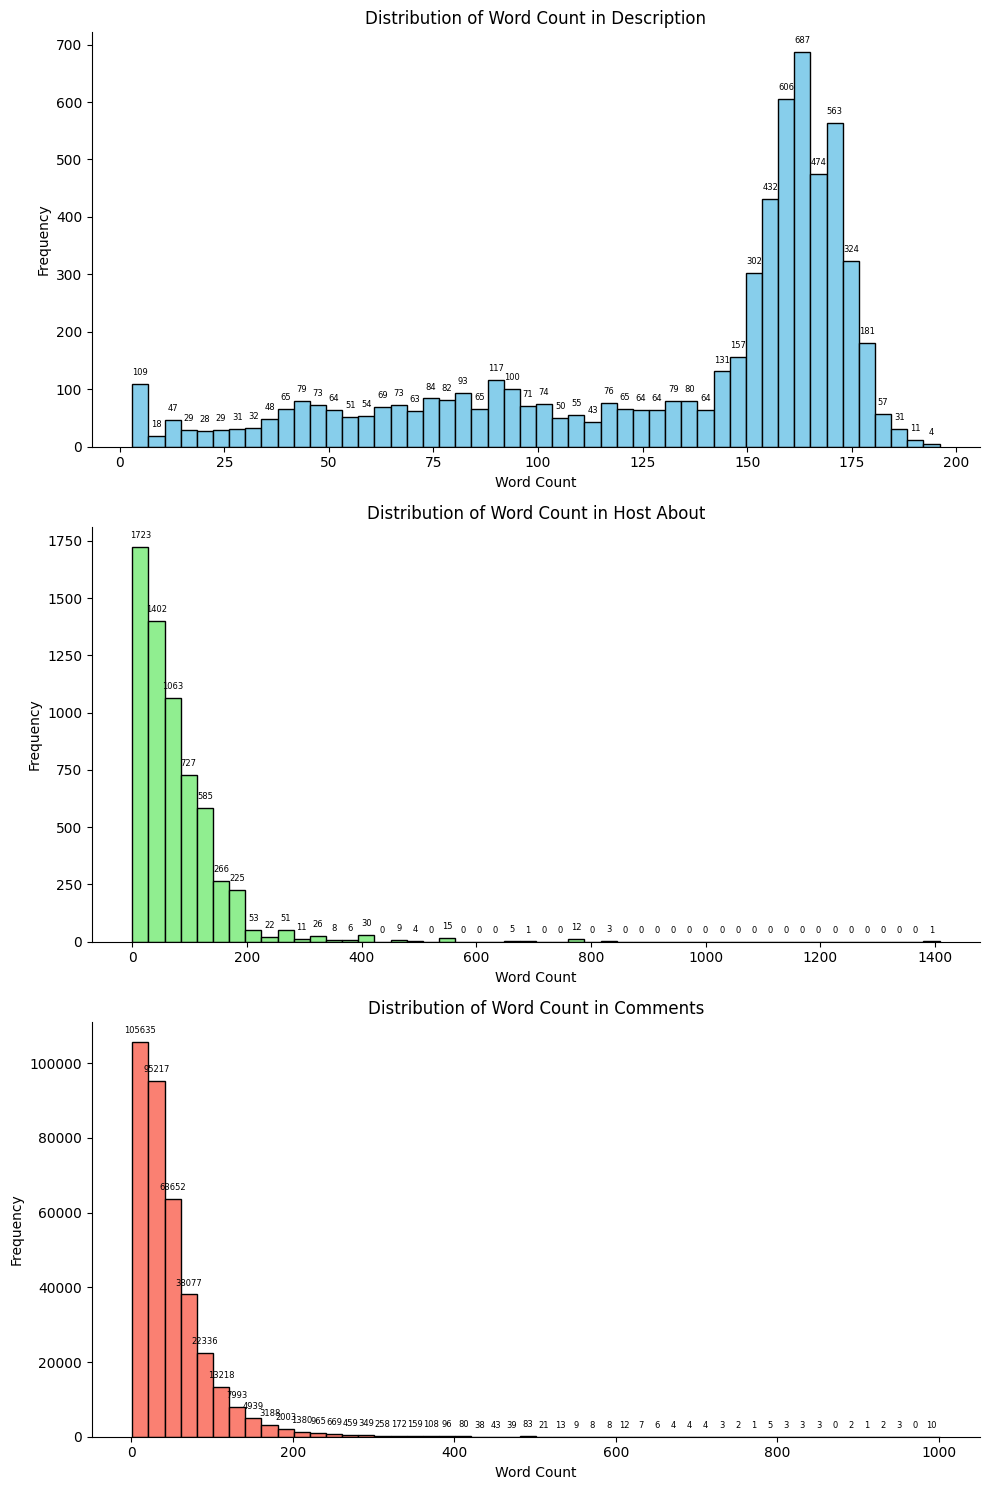

In [13]:
# Count words in 'Description' column
train_host_translated['word_count_description'] = train_host_translated['description'].apply(lambda x: len(str(x).split()))

# Count words in 'Host_about' column
train_host_translated['word_count_about'] = train_host_translated['host_about'].apply(lambda x: len(str(x).split()))

# Count words in 'Comments' column
train_reviews_translated['word_count_comments'] = train_reviews_translated['comments'].apply(lambda x: len(str(x).split()))

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

counts_desc, bins_desc, _ = axs[0].hist(train_host_translated['word_count_description'], bins=50, color='skyblue', edgecolor='black')
axs[0].grid(False)
axs[0].set_title('Distribution of Word Count in Description')
axs[0].set_xlabel('Word Count')
axs[0].set_ylabel('Frequency')

counts_about, bins_about, _ = axs[1].hist(train_host_translated['word_count_about'], bins=50, color='lightgreen', edgecolor='black')
axs[1].grid(False)
axs[1].set_title('Distribution of Word Count in Host About')
axs[1].set_xlabel('Word Count')
axs[1].set_ylabel('Frequency')

counts_comments, bins_comments, _ = axs[2].hist(train_reviews_translated['word_count_comments'], bins=50, color='salmon', edgecolor='black')
axs[2].grid(False)
axs[2].set_title('Distribution of Word Count in Comments')
axs[2].set_xlabel('Word Count')
axs[2].set_ylabel('Frequency')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add annotations to the top of each bar
for ax, counts, bins in zip(axs, [counts_desc, counts_about, counts_comments], [bins_desc, bins_about, bins_comments]):
    for count, bin_edge in zip(counts, bins):
        ax.annotate(str(int(count)), xy=(bin_edge + (bins[1] - bins[0]) / 2, count),
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

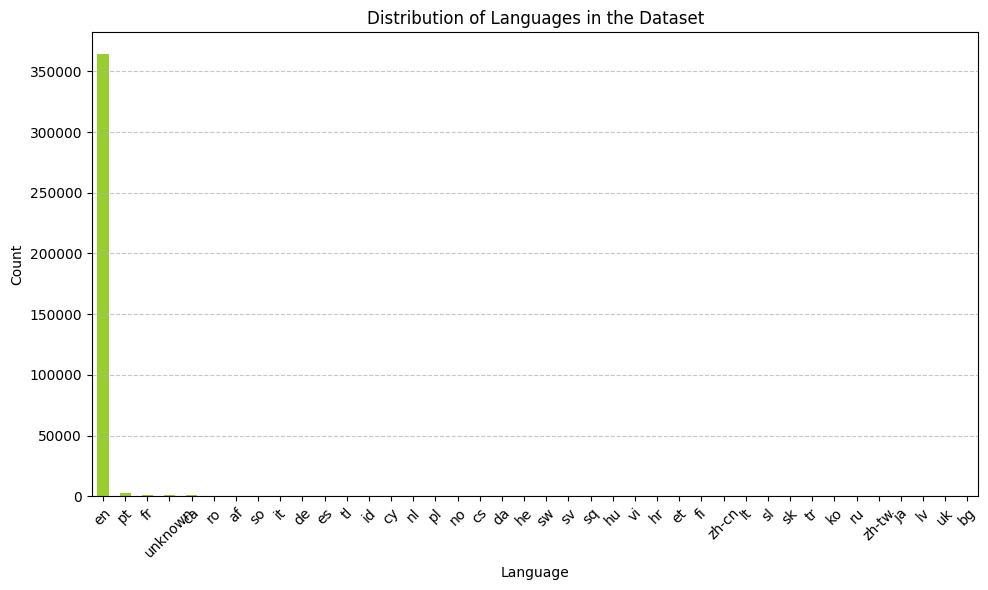

In [22]:
# Concatenate all text columns into a single Series
text_series = pd.concat([train_host_translated['description'], train_host_translated['host_about'], train_reviews_translated['comments']], ignore_index=True)

# Define a function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'  # Handling cases where language detection fails

# Apply language detection function to each text
detected_languages = text_series.apply(detect_language)

# Count the number of unique languages and print the names of the languages along with their counts
language_counts = detected_languages.value_counts()

# Plotting
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', color='yellowgreen')
plt.title('Distribution of Languages in the Dataset')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Merge Dataset

In [13]:
# Ensure all comments are strings
train_reviews_translated['comments_cleaned'] = train_reviews_translated['comments_cleaned'].astype(str)

# Group by 'index' and join comments
train_reviews_translated = train_reviews_translated.groupby('index')['comments_cleaned'].apply(lambda x: " ".join(x)).reset_index()
train_reviews_translated

index                                   comments_cleaned
0         1  cozy comfortable house stay never worry safety...
1         5  beautiful apartment magnificent view beach sea...
2         8  shani helpful throughout process thank answeri...
3         9  good stay isabel helder apartment well located...
4        10  wow great stay spacious apartment brand new su...
...     ...                                                ...
4240   6244  excellent host kind fast friendly central exce...
4241   6245  newly nicely refurbished apartment may perfect...
4242   6246  recommend host extremely hard communicate woul...
4243   6247  maria amazing host entire place cozy nice real...
4244   6248  ana great host helped u everything needed apar...

[4245 rows x 2 columns]

In [14]:
train_host_translated = train_host_translated.drop(columns=['description', 'host_about', 'word_count_description', 'word_count_host_about'])
train_host_translated

index  unlisted                                description_cleaned  \
0         1         0  shared mixed room hostel shared bathroom locat...   
1         2         1  meu espaço fica perto de parque eduardo vii sa...   
2         3         1  trafaria house cozy familiar villa facility ne...   
3         4         0  apartamento charmoso chiado entre largo carmo ...   
4         5         0  joli appartement en bordure de mer min pied de...   
...     ...       ...                                                ...   
6243   6244         0  studio new well decorated cozy apartment great...   
6244   6245         0  lisbon meet cosmopolitan industrial one bedroo...   
6245   6246         1                          b license number b exempt   
6246   6247         0  campo pequeno prestige classy top quality apar...   
6247   6248         0  apartment well located good neighborhood min c...   

                                     host_about_cleaned  
0                          alojamento local registro al  
1     friendly host try always around need anything ...  
2     social person liking communicate reading trave...  
3     hello portuguese love meet people around word ...  
4     nous somme une famille avec deux enfants de et...  
...                                                 ...  
6243  brand manager lisbon portugal grew macau south...  
6244  home feeling visitor let comfort reflect big p...  
6245  travel agent passionate culture welcome guest ...  
6246            família portugal gavião música passeios  
6247  base da minha vida é minha família e minha pai...  

[6248 rows x 4 columns]

In [15]:
# merge datasets
merged_train = pd.merge(train_host_translated, train_reviews_translated, on='index', how='left')
merged_train.head()

index  unlisted                                description_cleaned  \
0      1         0  shared mixed room hostel shared bathroom locat...   
1      2         1  meu espaço fica perto de parque eduardo vii sa...   
2      3         1  trafaria house cozy familiar villa facility ne...   
3      4         0  apartamento charmoso chiado entre largo carmo ...   
4      5         0  joli appartement en bordure de mer min pied de...   

                                  host_about_cleaned  \
0                       alojamento local registro al   
1  friendly host try always around need anything ...   
2  social person liking communicate reading trave...   
3  hello portuguese love meet people around word ...   
4  nous somme une famille avec deux enfants de et...   

                                    comments_cleaned  
0  cozy comfortable house stay never worry safety...  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4  beautiful apartment magnificent view beach sea...

# Train/Validation split

In [16]:
#train val split 0.7 - 0.3

merged_train['unlisted'] = merged_train['unlisted'].astype(int)
X = merged_train[['index','description_cleaned', 'host_about_cleaned', 'comments_cleaned']]
y = merged_train['unlisted']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
X_train.shape

(4373, 4)

In [18]:
X_val.shape

(1875, 4)

# Missing Values

In [19]:
# check missing values
X_train.isna().sum()

index                     0
description_cleaned       0
host_about_cleaned        0
comments_cleaned       1385
dtype: int64

In [20]:
#print some lines with missing comments
X_train[X_train['comments_cleaned'].isna()].head()

index                                description_cleaned  \
4710   4711  bright brand new bedroom rent student young wo...   
5056   5057  relaxe com toda família neste alojamento tranq...   
5841   5842  apartment lisbon bedroom capacity people apart...   
5615   5616  dieser gemütlichen unterkunft wirst eine tolle...   
1753   1754  private ensuite double room set twin also upst...   

                                     host_about_cleaned comments_cleaned  
4710  hellooo joana mother two beautiful princess ar...              NaN  
5056  lisboeta de gema viajante de mochila às costa ...              NaN  
5841  feel like home holiday rental company born uni...              NaN  
5615  international family studied worked several co...              NaN  
1753                          best thing surf sun beach              NaN

In [21]:
# Is there any comment missing which the index appear more than once ?
any(X_train[X_train['comments_cleaned'].isna().index.value_counts()!=1])

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14452\2629073526.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  any(X_train[X_train['comments_cleaned'].isna().index.value_counts()!=1])


True

In [22]:
# check missing values
X_val.isna().sum()

index                    0
description_cleaned      0
host_about_cleaned       0
comments_cleaned       618
dtype: int64

In [23]:
# Is there any comment missing which the index appear more than once ?
any(X_val[X_val['comments_cleaned'].isna().index.value_counts()!=1])

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14452\2089245961.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  any(X_val[X_val['comments_cleaned'].isna().index.value_counts()!=1])


True

# Duplicate Values

In [24]:
#check duplicates
print(f"{X_train.duplicated().sum()} duplicates in the training set")

print(f"{(X_train.duplicated().sum() / len(X_train)) * 100:.2f}% duplicates in the training set")

0 duplicates in the training set
0.00% duplicates in the training set


In [25]:
#check duplicates
print(f"{X_val.duplicated().sum()} duplicates in the validation set")

print(f"{(X_val.duplicated().sum() / len(X_val)) * 100:.2f}% duplicates in the validation set")

0 duplicates in the validation set
0.00% duplicates in the validation set


In [26]:
# Combine X and y to drop duplicates and NAs in X if any
combined = pd.concat([X_train, y_train.rename('target')], axis=1)

combined_cleaned = combined.fillna("without comments").drop_duplicates()

X_train= combined_cleaned.drop('target', axis=1)
y_train = combined_cleaned['target']

In [27]:
# Combine X and y to drop duplicates and NAs in X if any
combined = pd.concat([X_val, y_val.rename('target')], axis=1)

combined_cleaned = combined.fillna("without comments").drop_duplicates()

X_val= combined_cleaned.drop('target', axis=1)
y_val = combined_cleaned['target']

# Feature Engineering

In [28]:
X_train.set_index('index', inplace=True)
X_train.head(10)

description_cleaned  \
index                                                      
2836   cool loft totally refurbished located typical ...   
4512   sea ya family surf house foi pensado por uma f...   
4177   apartment well located minute walk marquês de ...   
65     casa da fé beautiful home magical sintra locat...   
1082   enjoy stay flat campo de ourique location neig...   
4711   bright brand new bedroom rent student young wo...   
5057   relaxe com toda família neste alojamento tranq...   
5034   recently renovated bedroom apartment full bath...   
5842   apartment lisbon bedroom capacity people apart...   
370    located noble emblematic neighbourhood middle ...   

                                      host_about_cleaned  \
index                                                      
2836   took degree psychology curently working area p...   
4512   apaixonados por mar viagens e gastronomia ma a...   
4177   olá sou brasileira viver em lisboa e estamos a...   
65     hi ida living beautiful sintra year really enj...   
1082   rita year old born raised lisbon house belongs...   
4711   hellooo joana mother two beautiful princess ar...   
5057   lisboeta de gema viajante de mochila às costa ...   
5034      friendly young guy like travel meet new people   
5842   feel like home holiday rental company born uni...   
370    hi name francisco yo half portuguese father ha...   

                                        comments_cleaned  
index                                                     
2836   place beautiful recently renovated everything ...  
4512   maria antonio great host first foremost incred...  
4177   comfortable place spend day much noise lot peo...  
65     lovely place perfect location friendly host go...  
1082   accommodation pleasant brand new beautiful pra...  
4711                                    without comments  
5057                                    without comments  
5034   everything good th time visiting lisbon far ai...  
5842                                    without comments  
370    amazing cozy flat great location apartment san...

In [29]:
X_val.set_index('index', inplace=True)
X_val.head(10)

description_cleaned  \
index                                                      
2326   important response covid property extended cle...   
2942   coliving space place want designed location in...   
5197   exclusive rustic loft terrace part centenary s...   
1064   quarto com camas individuais casa de banho pri...   
5105   area principe real lisboa happy welcome lisbon...   
1841   cosy apartment situated heart wall saint jorge...   
2019   situated min beautiful city lisbon beautiful b...   
6056   new double bedroom shared toilet bd wc buildin...   
5177   bright duplex apartment quiet street close sub...   
4099   apartment located historic center lisbon histo...   

                                      host_about_cleaned  \
index                                                      
2326   hi homing company develops activity tourism pr...   
2942   outsite provides place live work play beautifu...   
5197   filipe poet engineer born sintra genuine local...   
1064   professora aposentada ensino secundário e da c...   
5105   dear guest take pride helping thousand busy ho...   
1841                                  somos lucia e luis   
2019   liam self employed past year running trophy bu...   
6056   hi fan travelling visited many place around wo...   
5177   born france came lisbon year ago like book mov...   
4099   sou psicóloga e trabalho na área organizaciona...   

                                        comments_cleaned  
index                                                     
2326                                    without comments  
2942   place amazing never stayed hostel absolutely l...  
5197   great stay clean tidy welcoming thank star lov...  
1064                                    without comments  
5105                                    without comments  
1841   wonderful week beautiful friendly experience r...  
2019   condo beautiful house front golf course wonder...  
6056   fantastic apartment host nice would definitely...  
5177   apartment comfortable subway near attraction n...  
4099   val kind helpful unfortunately apartment expec...

In [30]:
X_train['combined_text'] = X_train['description_cleaned'] + ' ' + X_train['host_about_cleaned'] + ' ' + X_train['comments_cleaned']
X_val['combined_text'] = X_val['description_cleaned'] + ' ' + X_val['host_about_cleaned'] + ' ' + X_val['comments_cleaned']

## Bag of Words (BoW)

In [32]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform the data
bow_train = vectorizer.fit_transform(X_train['combined_text'])

# Transform the test data using the same vectorizer
bow_val = vectorizer.transform(X_val['combined_text'])

# Print the vocabulary (unique words in the corpus)
print("Vocabulary:", vectorizer.get_feature_names_out())

# Print the BoW representation of the training and test data
print("Bag of Words representation for training data:")
print(bow_train.toarray())

print("Bag of Words representation for test data:")
print(bow_val.toarray())

Vocabulary: ['aa' 'aaa' 'aaaa' ... 'übersiedeln' 'überwältigend' 'übrigens']
Bag of Words representation for training data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Bag of Words representation for test data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## BertTokenizer

In [33]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input text
tokenized_texts_train = [tokenizer.tokenize(text) for text in X_train['combined_text']]

# Print the tokenized output for the first entry as an example
print("Tokenized Output for the first entry:", tokenized_texts_train[0])

# Convert tokens to token IDs
token_ids_train = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts_train]

# Print the token IDs for the first entry as an example
print("Token IDs for the first entry:", token_ids_train[0])

Tokenized Output for the first entry: ['cool', 'loft', 'totally', 'refurbished', 'located', 'typical', 'qui', '##ser', 'lisbon', 'street', 'vibrant', 'area', 'b', 'license', 'number', 'b', 'al', 'took', 'degree', 'psychology', 'cure', '##ntly', 'working', 'area', 'proud', 'mother', 'three', 'great', 'kid', 'love', 'travelling', 'visited', 'country', 'also', 'like', 'reading', 'art', 'general', 'lisbon', 'portugal', 'fan', 'pleased', 'help', 'information', 'might', 'need', 'city', 'country', 'also', 'food', 'lover', 'feel', 'free', 'ask', 'nice', 'restaurant', 'place', 'beautiful', 'recently', 'renovated', 'everything', 'new', 'apartment', 'bed', 'incredibly', 'comfortable', 'apartment', 'located', 'close', 'lot', 'great', 'bar', 'close', 'water', 'in', '##es', 'kind', 'sat', 'explain', 'various', 'sight', 'place', 'visit', 'stay', 'wonderful', 'highly', 'recommend', 'staying', 'in', '##es', 'absolute', 'ideal', 'air', '##bn', '##b', 'host', 'in', '##es', 'super', 'friendly', 'available

In [34]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input text
tokenized_texts_val = [tokenizer.tokenize(text) for text in X_val['combined_text']]

# Print the tokenized output for the first entry as an example
print("Tokenized Output for the first entry:", tokenized_texts_val[0])

# Convert tokens to token IDs
token_ids_val = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts_val]

# Print the token IDs for the first entry as an example
print("Token IDs for the first entry:", token_ids_val[0])

Tokenized Output for the first entry: ['important', 'response', 'co', '##vid', 'property', 'extended', 'cleaning', 'di', '##sin', '##fect', '##ion', 'measure', 'protocol', 'guarantee', 'safety', 'guest', 'apartment', 'declared', 'clean', 'safe', 'portuguese', 'authority', 'tu', '##ris', '##mo', 'de', 'portugal', 'b', 'space', 'b', 'important', 'response', 'co', '##vid', 'property', 'extended', 'cleaning', 'di', '##sin', '##fect', '##ion', 'measure', 'protocol', 'guarantee', 'safety', 'guest', 'apartment', 'declared', 'clean', 'safe', 'portuguese', 'authority', 'tu', '##ris', '##mo', 'de', 'portugal', 'guest', 'handed', 'individual', 'protection', 'kit', 'amazing', 'terrace', 'st', '##yl', '##ish', 'large', 'apartment', 'recently', 'refurbished', 'decorated', 'located', 'middle', 'one', 'lisbon', 'main', 'avenue', 'ave', '##ni', '##da', 'al', '##mir', '##ante', 'de', 'real', 'go', 'lisbon', 'downtown', 'minute', 'foot', 'intend', '##ente', 'metro', 'station', 'next', 'apartment', 'door'

In [35]:
# Initialize max_length to a small value
max_length = 0

# Iterate through tokenized_texts_train to find the maximum length
for tokens in tokenized_texts_train:
    # Calculate the length of the current sequence
    length = len(tokens)
    # Update max_length if the current sequence is longer
    if length > max_length:
        max_length = length

# Print the maximum length
print("Maximum length of the longest sentence:", max_length)

Maximum length of the longest sentence: 26612


In [36]:
# Define maximum sequence length
max_length = 26612

# Pad or truncate tokenized sequences
padded_token_ids_train = pad_sequences(token_ids_train, maxlen=max_length, padding='post', truncating='post')
padded_token_ids_val = pad_sequences(token_ids_val, maxlen=max_length, padding='post', truncating='post')


In [37]:
padded_token_ids_val.shape

(1875, 26612)

## TF-IDF 1-Gram

In [37]:
# Create a TfidfVectorizer object
tfidf = TfidfVectorizer()

In [44]:
# Transform
X_train_tfidf = tfidf.fit_transform(X_train['combined_text'])
X_val_tfidf = tfidf.transform(X_val['combined_text'])

In [45]:
print(X_train_tfidf.shape)

(4373, 58357)


In [ ]:
print(X_val_tfidf.shape)

In [46]:
# Creating a DataFrame for the TF-IDF matrix of X_train
df_train = pd.DataFrame(X_train_tfidf[0].T.todense(), index=tfidf.get_feature_names_out(), columns=["TF-IDF"])

# Sorting the DataFrame by TF-IDF values in descending order
df_train = df_train.sort_values('TF-IDF', ascending=False)

# Printing the top 25 terms with highest TF-IDF scores
print(df_train.head(25))

               TF-IDF
ines         0.560860
inês         0.477110
apartment    0.254642
great        0.181923
stay         0.136553
location     0.132574
clean        0.132153
loft         0.129395
lisbon       0.114387
recommend    0.111756
place        0.110989
everything   0.099397
host         0.098798
well         0.098257
perfect      0.092428
inès         0.083029
would        0.077124
really       0.075434
nice         0.070633
located      0.070426
time         0.067796
comfortable  0.067049
good         0.064348
wine         0.058952
highly       0.058475


In [49]:
# Creating a DataFrame for the TF-IDF matrix of X_val
df_val = pd.DataFrame(X_val_tfidf[0].T.todense(), index=tfidf.get_feature_names_out(), columns=["TF-IDF"])

# Sorting the DataFrame by TF-IDF values in descending order
df_val = df_val.sort_values('TF-IDF', ascending=False)

# Printing the top 25 terms with highest TF-IDF scores
print(df_val.head(25))

                TF-IDF
declared      0.275344
authority     0.240614
protocol      0.226221
disinfection  0.216352
measure       0.211219
turismo       0.200956
guarantee     0.191602
safety        0.170207
extended      0.170061
guest         0.155950
covid         0.151441
apartment     0.146585
lisbon        0.144372
slogan        0.143802
develops      0.143802
almirante     0.139789
support       0.136736
unforgetable  0.131736
homing        0.130211
service       0.126891
protection    0.123049
de            0.111335
response      0.109585
intendente    0.109164
handed        0.107042


## TF-IDF 2-Grams and 3-Grams

In [31]:
# Define the TF-IDF vectorizer with desired N-gram range
ngram_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 3))

In [32]:
# Fit and transform the text data
X_train_ngram = ngram_tfidf.fit_transform(X_train['combined_text'])

In [33]:
# Sum the TF-IDF scores for each term across all documents
tfidf_scores = np.array(X_train_ngram.sum(axis=0)).flatten()

# Get the feature names
feature_names = ngram_tfidf.get_feature_names_out()

# Create a DataFrame to store terms and their corresponding TF-IDF scores
tfidf_df = pd.DataFrame({'term': feature_names, 'score': tfidf_scores})

# Sort the DataFrame by TF-IDF scores in descending order
tfidf_df = tfidf_df.sort_values('score', ascending=False)

# Display the top terms
print(tfidf_df.head())

              term       score
276059   apartment  315.114293
2222821      great  215.145996
2954998   location  174.019361
4727963       stay  171.323491
3819258      place  152.451687


In [34]:
# Fit and transform the text data
X_val_ngram = ngram_tfidf.transform(X_val['combined_text'])

In [35]:
# Sum the TF-IDF scores for each term across all documents
tfidf_scores = np.array(X_val_ngram.sum(axis=0)).flatten()

# Get the feature names
feature_names = ngram_tfidf.get_feature_names_out()

# Create a DataFrame to store terms and their corresponding TF-IDF scores
tfidf_df = pd.DataFrame({'term': feature_names, 'score': tfidf_scores})

# Sort the DataFrame by TF-IDF scores in descending order
tfidf_df = tfidf_df.sort_values('score', ascending=False)

# Display the top terms
print(tfidf_df.head())

              term       score
276059   apartment  159.479694
2222821      great  107.990081
2954998   location   86.776821
4727963       stay   85.753263
3819258      place   76.490981


# Classification

In [36]:
labels = {"Unlisted": 1, "Listed": 0}

## K-Nearest Neighbors

In [36]:
modelknn = KNeighborsClassifier()

# Define parameter distributions for the RandomizedSearchCV
param_dist = {
    'n_neighbors': randint(1, 15), 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']  
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=modelknn, param_distributions=param_dist, n_iter=10, random_state=42)

### Bag of Words

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Best cross-validation accuracy: 0.82
              precision    recall  f1-score   support

    Unlisted       0.89      0.89      0.89      1362
      Listed       0.70      0.70      0.70       513

    accuracy                           0.84      1875
   macro avg       0.79      0.80      0.79      1875
weighted avg       0.84      0.84      0.84      1875

Training set accuracy: 0.88


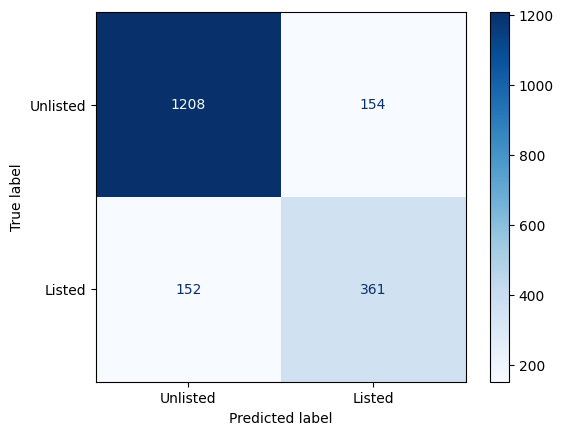

In [42]:
# Perform the randomized search
random_search.fit(bow_train, y_train)

# Print the best parameters and corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_knn = random_search.best_estimator_
y_pred_knn = best_knn.predict(bow_val)
y_pred_knn_train = best_knn.predict(bow_train)

# Evaluation
print(classification_report(y_val, y_pred_knn, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_knn_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### BertTokenizer

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
Best cross-validation accuracy: 0.83
              precision    recall  f1-score   support

    Unlisted       0.90      0.88      0.89      1362
      Listed       0.71      0.74      0.72       513

    accuracy                           0.84      1875
   macro avg       0.80      0.81      0.81      1875
weighted avg       0.85      0.84      0.85      1875

Training set accuracy: 1.00


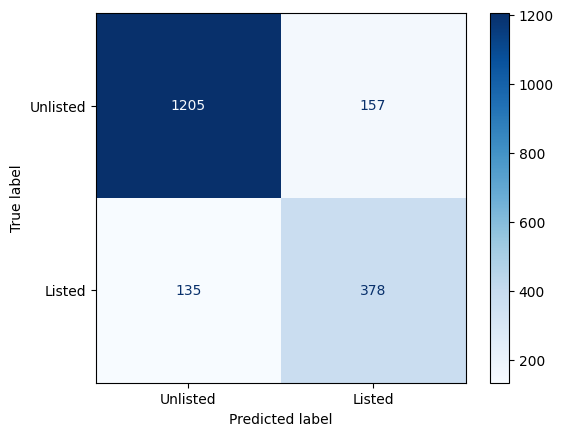

In [ ]:
# Perform the random search
random_search.fit(padded_token_ids_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_knn = random_search.best_estimator_
y_pred_knn = best_knn.predict(padded_token_ids_val)
y_pred_knn_train = best_knn.predict(padded_token_ids_train)

# Evaluation
print(classification_report(y_val, y_pred_knn, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_knn_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [50]:
# Save the model, random search results, and evaluation metrics
results = {
    'best_params': random_search.best_params_,
    'best_score': random_search.best_score_,
    'classification_report': classification_report(y_val, y_pred_knn, target_names=labels.keys(), output_dict=True),
    'train_accuracy': train_accuracy,
    'confusion_matrix': cm
}

joblib.dump(best_knn, 'best_knn_model.joblib')
joblib.dump(results, 'training_results.joblib')

print("Model and results have been saved.")

Model and results have been saved.


### TF-IDF 1-Gram

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Best cross-validation accuracy: 0.84
              precision    recall  f1-score   support

    Unlisted       0.86      0.94      0.90      1362
      Listed       0.78      0.60      0.68       513

    accuracy                           0.85      1875
   macro avg       0.82      0.77      0.79      1875
weighted avg       0.84      0.85      0.84      1875

Training set accuracy: 1.00


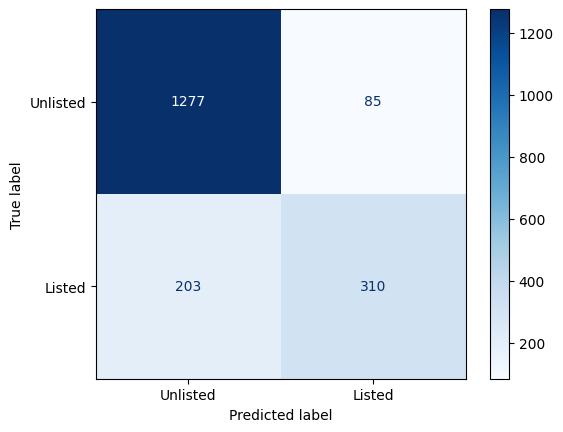

In [60]:
# Perform the grid search
random_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_knn = random_search.best_estimator_
y_pred_knn = best_knn.predict(X_val_tfidf)
y_pred_knn_train = best_knn.predict(X_train_tfidf)

# Evaluation
print(classification_report(y_val, y_pred_knn, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_knn_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### TF-IDF 2-Grams

In [ ]:
# Perform the grid search
random_search.fit(X_train_ngram, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_knn = random_search.best_estimator_
y_pred_knn = best_knn.predict(X_val_ngram)
y_pred_knn_train = best_knn.predict(X_train_ngram)

# Evaluation
print(classification_report(y_val, y_pred_knn, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_knn_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Best parameters found:  {'weights': 'distance', 'n_neighbors': 4, 'metric': 'euclidean'}
# Best cross-validation accuracy: 0.81

## Logistic Regression

In [38]:
# Define the parameter grid for Logistic Regression
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0, 0.5, 1]  # Only used if penalty is 'elasticnet'
}

# Initialize the Logistic Regression model
model_lr = LogisticRegression(max_iter=1000)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model_lr, param_distributions=param_dist, n_iter=10, random_state=42)


### Bag of Words

In [ ]:
random_search.fit(bow_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_lr = random_search.best_estimator_
y_pred_lr = best_lr.predict(bow_val)
y_pred_lr_train = best_lr.predict(bow_train)

# Evaluation
print(classification_report(y_val, y_pred_lr, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_lr_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Best parameters found:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 0.1}
# Best cross-validation accuracy: 0.86

### BertTokenizer

c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear

Best parameters found:  {'solver': 'liblinear', 'penalty': 'l2', 'l1_ratio': 1, 'C': 1}
Best cross-validation accuracy: 0.74
              precision    recall  f1-score   support

    Unlisted       0.87      0.77      0.81      1362
      Listed       0.53      0.69      0.60       513

    accuracy                           0.75      1875
   macro avg       0.70      0.73      0.70      1875
weighted avg       0.77      0.75      0.75      1875

Training set accuracy: 0.90


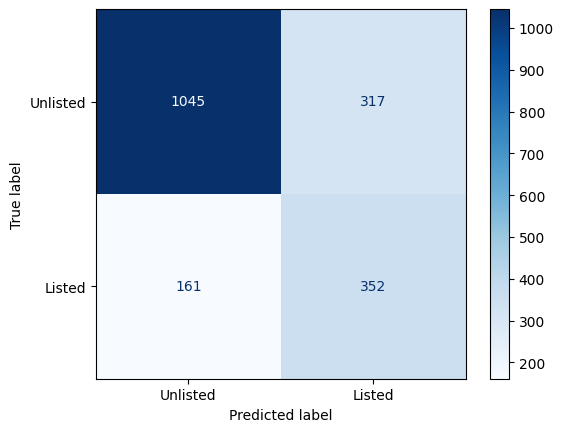

In [39]:
random_search.fit(padded_token_ids_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_lr = random_search.best_estimator_
y_pred_lr = best_lr.predict(padded_token_ids_val)
y_pred_lr_train = best_lr.predict(padded_token_ids_train)

# Evaluation
print(classification_report(y_val, y_pred_lr, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_lr_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [51]:
# Save the model, random search results, and evaluation metrics
results = {
    'best_params': random_search.best_params_,
    'best_score': random_search.best_score_,
    'classification_report': classification_report(y_val, y_pred_lr, target_names=labels.keys(), output_dict=True),
    'train_accuracy': train_accuracy,
    'confusion_matrix': cm
}

joblib.dump(best_lr, 'best_lr_model.joblib')
joblib.dump(results, 'training_results.joblib')

print("Model and results have been saved.")

Model and results have been saved.


### TF-IDF 1 Gram

In [ ]:
random_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_lr = random_search.best_estimator_
y_pred_lr = best_lr.predict(X_val_tfidf)
y_pred_lr_train = best_lr.predict(X_train_tfidf)

# Evaluation
print(classification_report(y_val, y_pred_lr, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_lr_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Best parameters found:  {'solver': 'liblinear', 'penalty': 'l1', 'l1_ratio': 1, 'C': 1}
# Best cross-validation accuracy: 0.87

### TF-IDF 2 Grams

c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
450 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\U

Best parameters found:  {'C': 100, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.76
              precision    recall  f1-score   support

    Unlisted       0.76      0.92      0.84      3632
      Listed       0.54      0.25      0.34      1367

    accuracy                           0.74      4999
   macro avg       0.65      0.58      0.59      4999
weighted avg       0.70      0.74      0.70      4999



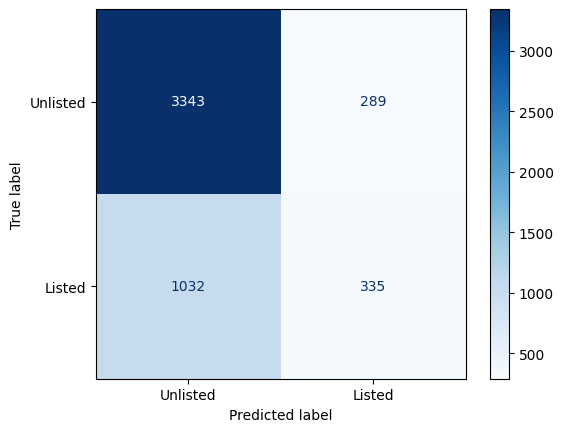

In [ ]:
random_search.fit(X_train_ngram, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_lr = random_search.best_estimator_
y_pred_lr = best_lr.predict(X_val_ngram)
y_pred_lr_train = best_lr.predict(X_train_ngram)

# Evaluation
print(classification_report(y_val, y_pred_lr, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_lr_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## MLP

In [38]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

modelmlp = MLPClassifier()()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model_lr, param_distributions=param_dist, n_iter=10, random_state=42)

### Bag of Words

In [ ]:
random_search.fit(bow_train, y_train)

# Print the best parameters and the corresponding scor
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_mlp = random_search.best_estimator_
y_pred_mlp = best_mlp.predict(bow_val)
y_pred_mlp_train = best_mlp.predict(bow_train)

# Evaluation
print(classification_report(y_val, y_pred_mlp, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_mlp_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Best parameters found:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
# Best cross-validation accuracy: 0.87

### BertTokenizer

In [ ]:
random_search.fit(padded_token_ids_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_mlp = random_search.best_estimator_
y_pred_mlp = best_mlp.predict(padded_token_ids_val)
y_pred_mlp_train = best_mlp.predict(padded_token_ids_train)

# Best parameters found:  {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}
# Best cross-validation accuracy: 0.82

              precision    recall  f1-score   support

    Unlisted       0.89      0.86      0.88      1362
      Listed       0.66      0.72      0.69       513

    accuracy                           0.82      1875
   macro avg       0.78      0.79      0.78      1875
weighted avg       0.83      0.82      0.83      1875

Training set accuracy: 0.82


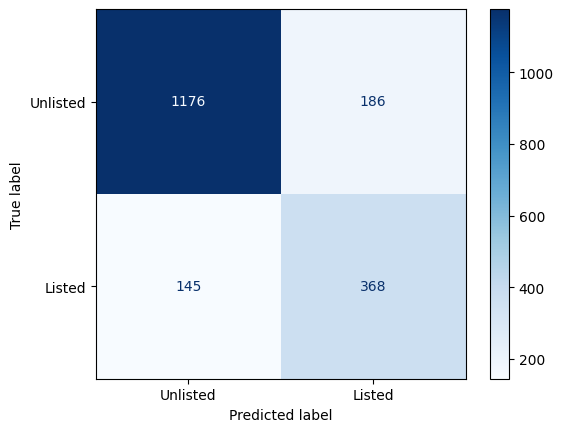

In [59]:
# Evaluation
print(classification_report(y_val, y_pred_mlp, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_mlp_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [60]:
# Save the model, random search results, and evaluation metrics
results = {
    'best_params': random_search.best_params_,
    'best_score': random_search.best_score_,
    'classification_report': classification_report(y_val, y_pred_mlp, target_names=labels.keys(), output_dict=True),
    'train_accuracy': train_accuracy,
    'confusion_matrix': cm
}

joblib.dump(best_mlp, 'best_mlp_model.joblib')
joblib.dump(results, 'training_results.joblib')

print("Model and results have been saved.")

Model and results have been saved.


### TF-IDF 1 Gram

In [ ]:
random_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_mlp = random_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_val_tfidf)
y_pred_mlp_train = best_mlp.predict(X_train_tfidf)

# Evaluation
print(classification_report(y_val, y_pred_mlp, target_names=labels.keys()))


# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_mlp_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Best parameters found:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
# Best cross-validation accuracy: 0.86

### TF-IDF 2 Grams

In [39]:
random_search.fit(X_train_ngram, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

# Use the best estimator to make predictions
best_mlp = random_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_val_ngram)
y_pred_mlp_train = best_lr.predict(X_train_ngram)

# Evaluation
print(classification_report(y_val, y_pred_mlp, target_names=labels.keys()))

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_mlp_train)
print("Training set accuracy: {:.2f}".format(train_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Best parameters found:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}
# Best cross-validation accuracy: 0.78

## LSTM

In [39]:
# function to calculate weighted f1-score because LSTM doesn't calculate it inherently
def weighted_f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    
    # Weighted F1 calculation
    weights = tf.reduce_sum(y_true, axis=0) / tf.reduce_sum(y_true)
    weighted_f1 = tf.reduce_sum(f1 * weights)
    
    return weighted_f1

### BertTokenizer

In [40]:
# Determine the maximum sequence length
max_len = max(len(seq) for seq in token_ids_train)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

# Define the LSTM model
input_ = Input(shape=(max_len,))
embedding_dim = 100  # Adjust as necessary

# Embedding layer
embedding_layer = Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim, input_length=max_len)(input_)

# Apply Masking layer
mask_layer = Masking(mask_value=0)(embedding_layer)

# Bidirectional LSTM layer
lstm = Bidirectional(LSTM(units=128, return_sequences=False))(mask_layer)  # Increased units for more complexity

# Dense layer with softmax activation for classification
output = Dense(2, activation='softmax')(lstm)  # Change the number of units to match the number of classes

# Define the model
model = Model(inputs=input_, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', weighted_f1_metric])
model.summary()

c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 26612)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 26612,     │  3,052,200 │ input_layer[0][0] │
│ (Embedding)         │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 26612,     │          0 │ embedding[0][0]   │
│ (NotEqual)          │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 26612,     │          0 │ embedding[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 26612)     │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    234,496 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        514 │ bidirectional[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,287,210 (12.54 MB)

 Trainable params: 3,287,210 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history1 = model.fit(padded_token_ids_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(padded_token_ids_val, y_val))

Epoch 1/2
137/137 ━━━━━━━━━━━━━━━━━━━━ 29911s 218s/step - accuracy: 0.7129 - loss: 0.6018 - weighted_f1_metric: 0.6068 - val_accuracy: 0.7264 - val_loss: 0.5492 - val_weighted_f1_metric: 0.6134
Epoch 2/2
  2/137 ━━━━━━━━━━━━━━━━━━━━ 9:49:34 262s/step - accuracy: 0.7188 - loss: 0.5394 - weighted_f1_metric: 0.6011

In [40]:
# Train the model
history2 = model.fit(padded_token_ids_train, y_train, batch_size=32, epochs=1, verbose=1, validation_data=(padded_token_ids_val, y_val))

 93/137 ━━━━━━━━━━━━━━━━━━━━ 3:18:06 270s/step - accuracy: 0.7148 - loss: 0.5951 - weighted_f1_metric: 0.6067

In [40]:
# Train the model
history3 = model.fit(padded_token_ids_train, y_train, batch_size=32, epochs=1, verbose=1, validation_data=(padded_token_ids_val, y_val))

137/137 ━━━━━━━━━━━━━━━━━━━━ 22876s 167s/step - accuracy: 0.7138 - loss: 0.5997 - weighted_f1_metric: 0.6063 - val_accuracy: 0.7264 - val_loss: 0.5748 - val_weighted_f1_metric: 0.6134


## Transformers

### BertTokenizer

In [ ]:
# Tokenize the input text and create attention masks
def tokenize_and_pad(text_list):
    input_ids = []
    attention_masks = []

    for text in text_list:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_length,    # Pad & truncate all sentences
            padding='max_length',     # Pad to max length
            truncation=True,          # Truncate to max length
            return_attention_mask=True,  # Construct attention masks
            return_tensors='pt',     # Return pytorch tensors
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Tokenize and pad the training data
input_ids_train, attention_masks_train = tokenize_and_pad(X_train['combined_text'].tolist())
input_ids_val, attention_masks_val = tokenize_and_pad(X_val['combined_text'].tolist())

# Convert labels to tensors and ensure they are of type Long
labels_train_tensor = torch.tensor(y_train.values).long()
labels_val_tensor = torch.tensor(y_val.values).long()

# Create TensorDatasets
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train_tensor)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=2)
val_dataloader = DataLoader(val_dataset, batch_size=2)

# Load pre-trained model
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name)

# Set the model to training mode
model.train()

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop (simplified)
for epoch in range(3):  #for 3 epochs
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item()}")

# Set the model to evaluation mode
model.eval()

In [ ]:
# Function to get predictions and true labels
def get_predictions(dataloader):
    predictions, true_labels = [], []

    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.append(labels.cpu().numpy())
    
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    
    return predictions, true_labels

# Get predictions and true labels for the validation set
predictions, true_labels = get_predictions(val_dataloader)

# Calculate precision, recall, F1 score, and support
precision, recall, f1, support = precision_recall_fscore_support(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Support: {support}")
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# Save the model, predictions, and metrics 
joblib.dump(model.state_dict(), 'bert_model.pth')
joblib.dump((predictions, true_labels), 'predictions.pkl')
joblib.dump((precision, recall, f1, support, accuracy), 'metrics.pkl')

In [ ]:
# Load the model state
model.load_state_dict(joblib.load('bert_model.pth'))

# Load predictions and labels
predictions, true_labels = joblib.load('predictions.pkl')

# Load metrics
precision, recall, f1, support, accuracy = joblib.load('metrics.pkl')

# Predictions on Test Data

In [31]:
test_host.head(10)

index                                        description  \
0      1  <b>The space</b><br />Apartment located in the...   
1      2  IMPORTANT: In response to COVID-19, this prope...   
2      3  Bright, beautiful, and spacious. This four-bed...   
3      4  Charming Apartment Close to the Bay of Cascais...   
4      5  Se procura umas férias perto da praia, casino ...   
5      6  Rustic house with strong typical characteristi...   
6      7  IMPORTANT: In response to COVID-19, this prope...   
7      8  Apartamento duplex inserido num edifício novo ...   
8      9  *****<br /><br />THE APARTMENT<br /><br />The ...   
9     10  Gorgeous bright one bedroom with sunny balcony...   

                                          host_about  
0  Gosto de viajar, de conhecer pessoas, gosto de...  
1  We are the be@home Team!\n\nYou can count on u...  
2  Hi there!\n\nWe're GuestReady, a professional ...  
3                                                 :)  
4  Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...  
5  Tenho 63 anos e sou reformado por invalidez. S...  
6  Homing has become one of the largest and most ...  
7  Sara & Hugo: Jovem casal, com atividade profis...  
8  Welcome to Lisbon ! I hope you feel at home in...  
9  Our mission is to make you feel like a friend ...

In [32]:
test_reviews.head(10)

index                                           comments
0      1  Thank you very much Antonio ! All has been per...
1      1  Very nice appartment in the old town of Lissab...
2      1  When travelling we're looking for kids friendl...
3      1  We've been in Lisbon in march 2013 (3 adults a...
4      1  Our host Antonio was very helpful with informa...
5      1  Very nice place to be. Large clean apartment._...
6      1  Everything was great!, Antonio and his mother ...
7      1  A very comfortable, clean and nice flat with a...
8      1  Séjour idéal, nous avons été  accueillis très ...
9      1                  I spent Great time at This place

## Data Exploration

In [34]:
test_host['word_count_description']  = test_host['description'].apply(lambda x: len(str(x).split(" ")))
test_host['word_count_host_about']  = test_host['host_about'].apply(lambda x: len(str(x).split(" ")))
test_reviews['word_count_comments']  = test_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
test_reviews.head()

index                                           comments  \
0      1  Thank you very much Antonio ! All has been per...   
1      1  Very nice appartment in the old town of Lissab...   
2      1  When travelling we're looking for kids friendl...   
3      1  We've been in Lisbon in march 2013 (3 adults a...   
4      1  Our host Antonio was very helpful with informa...   

   word_count_comments  
0                   33  
1                   41  
2                   97  
3                   49  
4                  131

In [35]:
test_host.head()

index                                        description  \
0      1  <b>The space</b><br />Apartment located in the...   
1      2  IMPORTANT: In response to COVID-19, this prope...   
2      3  Bright, beautiful, and spacious. This four-bed...   
3      4  Charming Apartment Close to the Bay of Cascais...   
4      5  Se procura umas férias perto da praia, casino ...   

                                          host_about  word_count_description  \
0  Gosto de viajar, de conhecer pessoas, gosto de...                     162   
1  We are the be@home Team!\n\nYou can count on u...                     147   
2  Hi there!\n\nWe're GuestReady, a professional ...                     179   
3                                                 :)                     166   
4  Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...                      41   

   word_count_host_about  
0                     23  
1                    105  
2                    135  
3                      1  
4                    120

In [36]:
# Concatenate all text columns into a single Series
text_series = pd.concat([test_host['description'], test_host['host_about'], test_reviews['comments']], ignore_index=True)

# function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'  # Handling cases where language detection fails

detected_languages = text_series.apply(detect_language)

language_counts = detected_languages.value_counts()

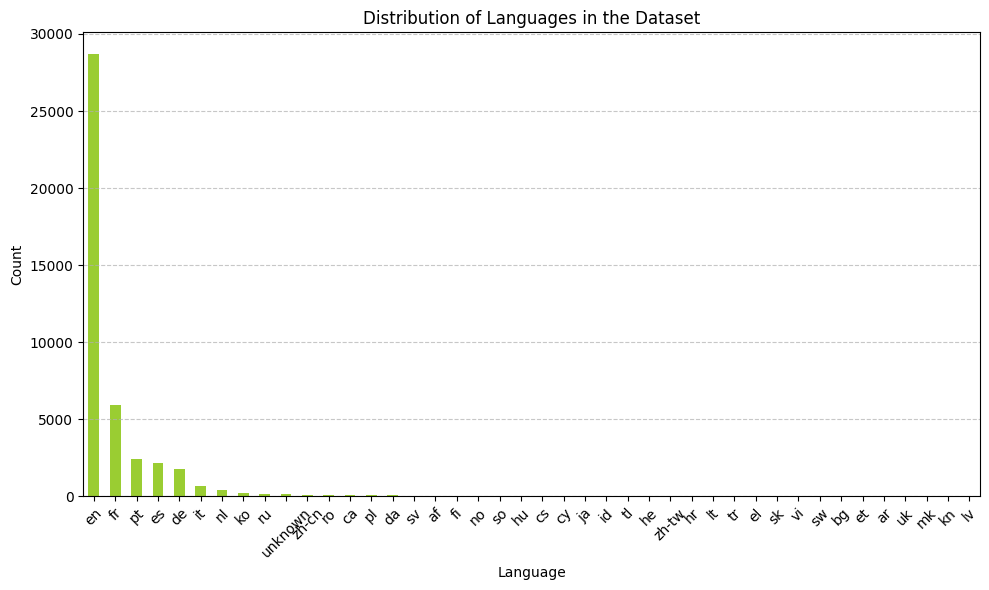

In [37]:
# Plot the distribution of languages
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', color='yellowgreen')
plt.title('Distribution of Languages in the Dataset')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

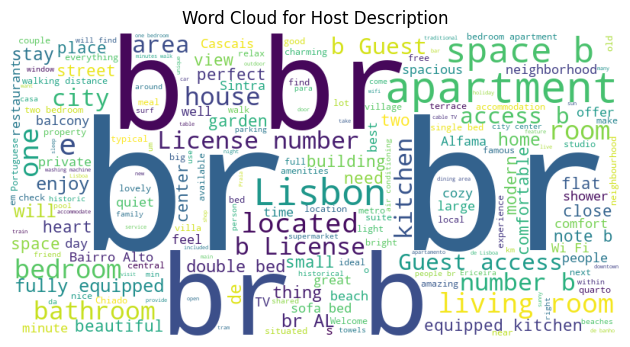

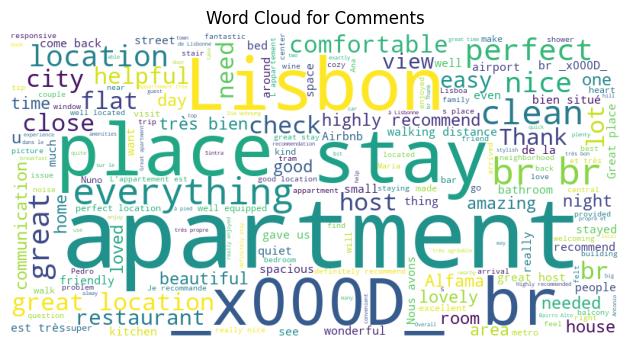

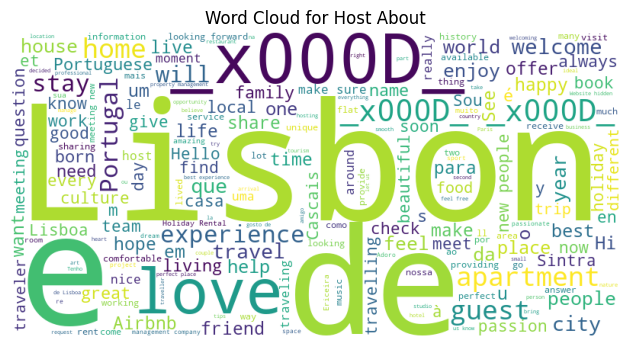

In [38]:
wordcloud_host = WordCloud(width=800, height=400, background_color="white").generate(' '.join(test_host['description']))
plt.imshow(wordcloud_host)
plt.title('Word Cloud for Host Description')
plt.axis("off")
plt.tight_layout()
plt.show()

wordcloud_reviews = WordCloud(width=800, height=400, background_color="white").generate(' '.join(test_reviews['comments'].astype(str)))
plt.imshow(wordcloud_reviews)
plt.title('Word Cloud for Comments')
plt.axis("off")
plt.tight_layout()
plt.show()

wordcloud_about = WordCloud(width=800, height=400, background_color="white").generate(' '.join(test_host['host_about']))
plt.imshow(wordcloud_about)
plt.title('Word Cloud for Host About')
plt.axis("off")
plt.tight_layout()
plt.show()

## Data Preprocessing

In [40]:
test_host_translated = pd.read_csv('test_host_translated.csv')
test_reviews_translated = pd.read_csv('translated_reviews_test.csv')

In [41]:
test_host_translated = clean(test_host_translated, 'description', lemmatize=True, stemmer=False)
test_host_translated = clean(test_host_translated, 'host_about', lemmatize=True, stemmer=False)
test_reviews_translated = clean(test_reviews_translated, 'comments', lemmatize=True, stemmer=False)

100%|██████████| 41866/41866 [00:13<00:00, 3089.39it/s]


## Re-check Data Exploration

In [42]:
# Concatenate all text columns into a single Series
text_series = pd.concat([test_host_translated['description'], test_host_translated['host_about'], test_reviews_translated['comments']], ignore_index=True)

# function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'  # Handling cases where language detection fails

detected_languages = text_series.apply(detect_language)

language_counts = detected_languages.value_counts()

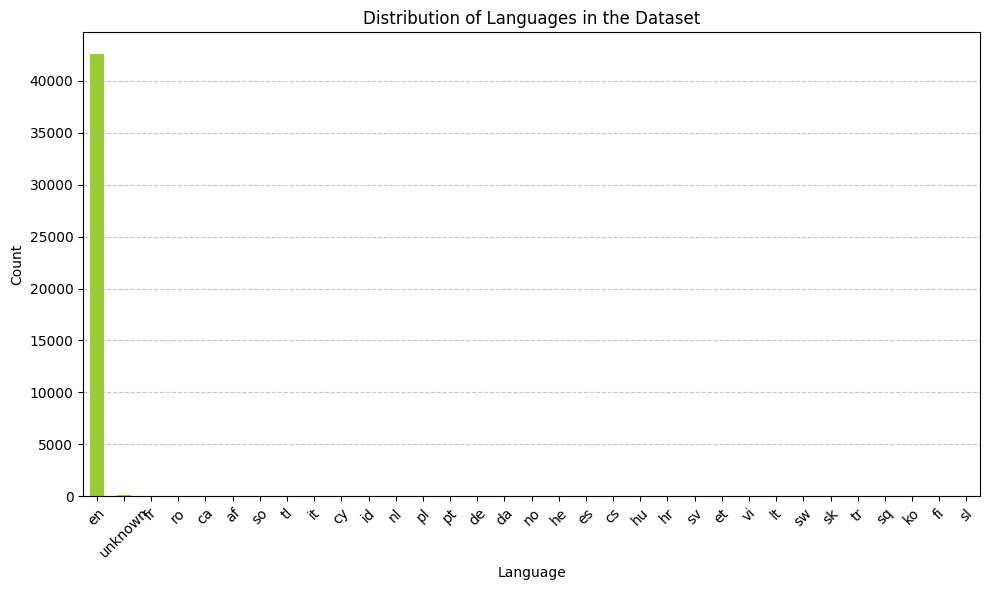

In [43]:
# Plot the distribution of languages
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', color='yellowgreen')
plt.title('Distribution of Languages in the Dataset')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

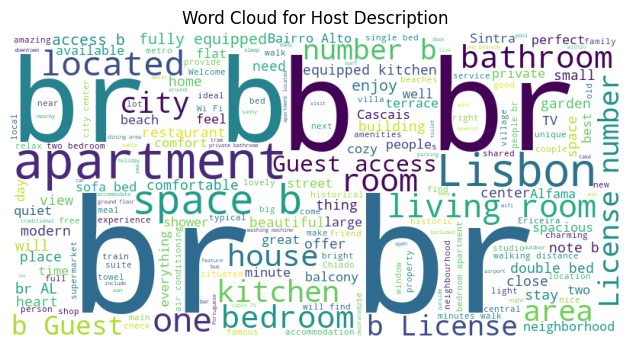

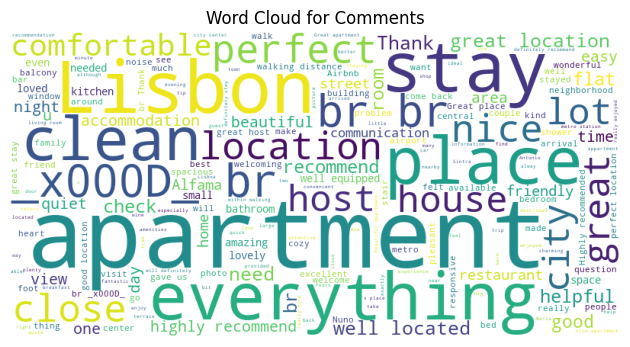

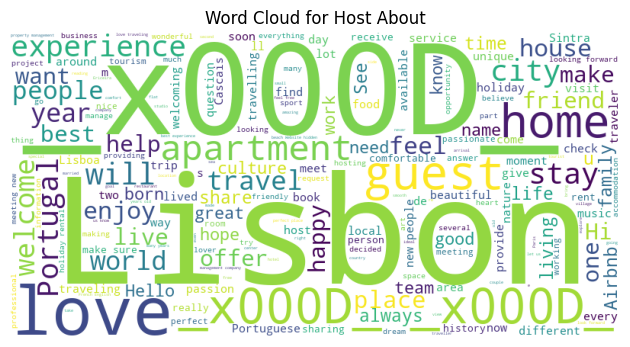

In [44]:
wordcloud_host = WordCloud(width=800, height=400, background_color="white").generate(' '.join(test_host_translated['description']))
plt.imshow(wordcloud_host)
plt.title('Word Cloud for Host Description')
plt.axis("off")
plt.tight_layout()
plt.show()

wordcloud_reviews = WordCloud(width=800, height=400, background_color="white").generate(' '.join(test_reviews_translated['comments'].astype(str)))
plt.imshow(wordcloud_reviews)
plt.title('Word Cloud for Comments')
plt.axis("off")
plt.tight_layout()
plt.show()

wordcloud_about = WordCloud(width=800, height=400, background_color="white").generate(' '.join(test_host_translated['host_about']))
plt.imshow(wordcloud_about)
plt.title('Word Cloud for Host About')
plt.axis("off")
plt.tight_layout()
plt.show()

## Merge Data

In [45]:
# Group by 'index' and join comments
test_reviews_translated = test_reviews_translated.groupby('index')['comments_cleaned'].apply(lambda x: " ".join(x)).reset_index()
test_reviews_translated

index                                   comments_cleaned
0        1  thank much antonio perfect stay appartment per...
1        2  beautiful bright apartment residential area li...
2        4  claudia great host met u train station bring u...
3        5  house exactly photo clean sheet towel smell li...
4        6  excellent realy grerat house feel like domesti...
..     ...                                                ...
470    690  alright wonderful apartment nice quiet communi...
471    691  delighted stay maria apartment welcomed u fres...
472    692  good quite place perfect location warm enough ...
473    694  manuel pedro available apartment particularly ...
474    695  pro apartment great location min walk main att...

[475 rows x 2 columns]

In [46]:
# Group by 'index' and join description_cleaned and host_about_cleaned
test_host_translated = test_host_translated.groupby('index').agg({
    'description_cleaned': lambda x: " ".join(x.astype(str)),
    'host_about_cleaned': lambda x: " ".join(x.astype(str))
}).reset_index()

test_host_translated

index                                description_cleaned  \
0        1  b space b apartment located historic center li...   
1        2  important response covid property extended cle...   
2        3  bright beautiful spacious four bedroom apartme...   
3        4  charming apartment close bay cascais bedroom d...   
4        5  looking holiday close beach casino tourist att...   
..     ...                                                ...   
690    691  brand new apartment xvicentury building amazin...   
691    692  located one iconic street lisbon enjoy charmin...   
692    693  b space b studio building renovated studio bra...   
693    694  charming apartment overwelming view several di...   
694    695  apartment terrace located heart lisbon next hi...   

                                    host_about_cleaned  
0    like traveling meeting people like receiving f...  
1    home team count u take care every single detai...  
2    hi guestready professional property management...  
3                                                       
4    welcome portugal love country also love gettin...  
..                                                 ...  
690  hi maria work cinema tv theater tv commercial ...  
691  hi guestready professional property management...  
692  hello name laetitia mean joy latin smile every...  
693  hi alexandra pedro brother sister great pleasu...  
694  founded travel enthusiast like bnbird want con...  

[695 rows x 3 columns]

In [47]:
merged_test = pd.merge(test_host, test_reviews, on='index', how='left')
merged_test.set_index('index', inplace=True)
merged_test

description  \
index                                                      
1      <b>The space</b><br />Apartment located in the...   
1      <b>The space</b><br />Apartment located in the...   
1      <b>The space</b><br />Apartment located in the...   
1      <b>The space</b><br />Apartment located in the...   
1      <b>The space</b><br />Apartment located in the...   
...                                                  ...   
695    Apartment with terrace located in the heart of...   
695    Apartment with terrace located in the heart of...   
695    Apartment with terrace located in the heart of...   
695    Apartment with terrace located in the heart of...   
695    Apartment with terrace located in the heart of...   

                                              host_about  \
index                                                      
1      Gosto de viajar, de conhecer pessoas, gosto de...   
1      Gosto de viajar, de conhecer pessoas, gosto de...   
1      Gosto de viajar, de conhecer pessoas, gosto de...   
1      Gosto de viajar, de conhecer pessoas, gosto de...   
1      Gosto de viajar, de conhecer pessoas, gosto de...   
...                                                  ...   
695    Founded by travel enthusiasts (just like you) ...   
695    Founded by travel enthusiasts (just like you) ...   
695    Founded by travel enthusiasts (just like you) ...   
695    Founded by travel enthusiasts (just like you) ...   
695    Founded by travel enthusiasts (just like you) ...   

       word_count_description  word_count_host_about  \
index                                                  
1                         162                     23   
1                         162                     23   
1                         162                     23   
1                         162                     23   
1                         162                     23   
...                       ...                    ...   
695                       162                     71   
695                       162                     71   
695                       162                     71   
695                       162                     71   
695                       162                     71   

                                                comments  word_count_comments  
index                                                                          
1      Thank you very much Antonio ! All has been per...                 33.0  
1      Very nice appartment in the old town of Lissab...                 41.0  
1      When travelling we're looking for kids friendl...                 97.0  
1      We've been in Lisbon in march 2013 (3 adults a...                 49.0  
1      Our host Antonio was very helpful with informa...                131.0  
...                                                  ...                  ...  
695                                 Everything was fine!                  3.0  
695                                    Very good located                  3.0  
695    Appartement confortable conforme aux photos bi...                 12.0  
695    Très bon logement pour un week-end prolongé à ...                 45.0  
695    The location for this apartment is great. You'...                 44.0  

[42086 rows x 6 columns]

## Missing Values

In [48]:
merged_test.isna().sum()

description                 0
host_about                  0
word_count_description      0
word_count_host_about       0
comments                  220
word_count_comments       220
dtype: int64

In [49]:
# Fill missing values in the test set
merged_test = merged_test.fillna("without comments")

In [50]:
merged_test.isna().sum()

description               0
host_about                0
word_count_description    0
word_count_host_about     0
comments                  0
word_count_comments       0
dtype: int64

## Duplicate Values

In [51]:
#check duplicates
print(f"{merged_test.duplicated().sum()} duplicates in the test set")

print(f"{(merged_test.duplicated().sum() / len(merged_test)) * 100:.2f}% duplicates in the test set")

15 duplicates in the test set
0.04% duplicates in the test set


## Predicting

In [52]:
merged_test['combined_text'] = merged_test['description'] + ' ' + merged_test['host_about'] + ' ' + merged_test['comments']

In [53]:
# Load the best model and vectorizer
loaded_model = joblib.load('best_logistic_regression_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Utilizador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Tryin

In [54]:
# Transform the test data using the loaded TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(merged_test['combined_text'])

In [55]:
# Make predictions using the best_model
predictions = loaded_model.predict(X_test_tfidf)

In [56]:
# Reset index before creating the predictions DataFrame
merged_test.reset_index(inplace=True)

# Create the 'output' directory 
os.makedirs('output', exist_ok=True)

# Storing predictions
predictions_df = pd.DataFrame({'index': merged_test['index'], 'prediction': predictions})

# Save the DataFrame to a CSV file without including column names
predictions_df.to_csv('output/Predictions.csv', index=False)

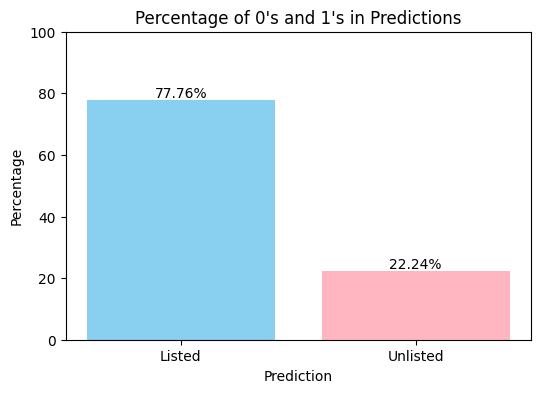

In [57]:
# Calculate the percentage of 0's and 1's
percentage_counts = predictions_df['prediction'].value_counts(normalize=True) * 100

# Plot the percentage of 0's and 1's
plt.figure(figsize=(6, 4))
plt.bar(percentage_counts.index, percentage_counts, color=['#89CFF0', '#FFB6C1'])  # Baby blue and baby pink colors
plt.xlabel('Prediction')
plt.ylabel('Percentage')
plt.title('Percentage of 0\'s and 1\'s in Predictions')
plt.xticks([0, 1], ['Listed', 'Unlisted'])
plt.ylim(0, 100)

# Add text annotations on the bars
for i, value in enumerate(percentage_counts):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center')

plt.show()

In [58]:
# Storing predictions

# Create a DataFrame with 'index' and 'predictions' columns
predictions_df = pd.DataFrame({'index': merged_test['index'], 'prediction': predictions})

# Save the DataFrame to a CSV file without including column names
predictions_df.to_csv('output/Predictions.csv', index=False)